# Preprocess CRC data

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import InSituData, InSituExperiment, CACHE
import scanpy as sc
from tqdm import tqdm

## Reload after proseg addition

In [3]:
data_path = Path(r"D:\ColorectalCancer\analysis\crc_data")

In [4]:
exp = InSituExperiment.read(data_path)
exp.load_all()

100%|██████████| 7/7 [00:12<00:00,  1.80s/it]


In [5]:
exp

InSituExperiment with 7 samples:
           uid  CITAR  slide_id       sample_id  Region  ...     Sample Name Metastasis type     H number              HE           panCK
0     3d377351  +++--      3621  Region_1-14...       1  ...  Colorectal ...             NaN  1414/18 IIA  C:\Users\ge...  C:\Users\ge...
1     039bf1f8  +++--      3621  Region_2-14...       2  ...  Lymph node ...     synchronous  1414/18 IIS  C:\Users\ge...  C:\Users\ge...
2     1c928862  +++--      3621  Region_3-33...       3  ...  Lung metast...    asynchronous  3311/18 IVA  C:\Users\ge...  C:\Users\ge...
3     18755ab6  +++--      3621  Region_4-14...       4  ...  Liver metas...     synchronous   1414/18 IC  C:\Users\ge...  C:\Users\ge...
4     3ee0776f  +++--      3991  Region_1-53...       1  ...  Colorectal ...             NaN  5316/18 IVC  C:\Users\ge...  C:\Users\ge...
5     4e08eb69  +++--      3991  Region_2-53...       2  ...  Lymph node ...     synchronous  5316/18 IVS  C:\Users\ge...  C:\Users\ge...
6

In [34]:
exp.show(0)

Viewer(camera=Camera(center=(0.0, 2906.04375, 3627.1625), zoom=0.02514288471180968, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 5812.299999999999, 0.2125), (0.0, 7254.537499999999, 0.2125)), current_step=(13675, 17069), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x20b14a367c0>, <Image layer 'HE' at 0x20b6c981d90>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='0003621: Region_1-1414_18_IIA', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x0000020B67472940>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

## Round the proseg counts

In [6]:
import numpy as np
from scipy.sparse import csr_matrix

In [7]:
for _, d in tqdm(exp.iterdata()):
    d.cells["proseg"].matrix.layers["counts_rounded"] = csr_matrix(np.round(d.cells["proseg"].matrix.X))

7it [00:00, 16.02it/s]


In [8]:
from insitupy.preprocessing import calculate_qc_metrics

## Filtering

In [11]:
from insitupy.plotting import plot_qc_metrics, test_transformations

In [12]:
cell_keys = ["main", "proseg"]

## Look into rounded proseg counts in one dataset

In [ ]:
xd = exp.data[0].copy()

In [ ]:

adata = xd.cells.matrix.copy()
proseg_adata = xd.cells["proseg"].matrix.copy()
proseg_adata_rounded = proseg_adata.copy()
proseg_adata_rounded.X = proseg_adata_rounded.layers["counts_rounded"]

#### Calculate QC metrics

In [27]:
sc.pp.calculate_qc_metrics(adata=adata, percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata=proseg_adata, percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata=proseg_adata_rounded, percent_top=None, log1p=False, inplace=True)

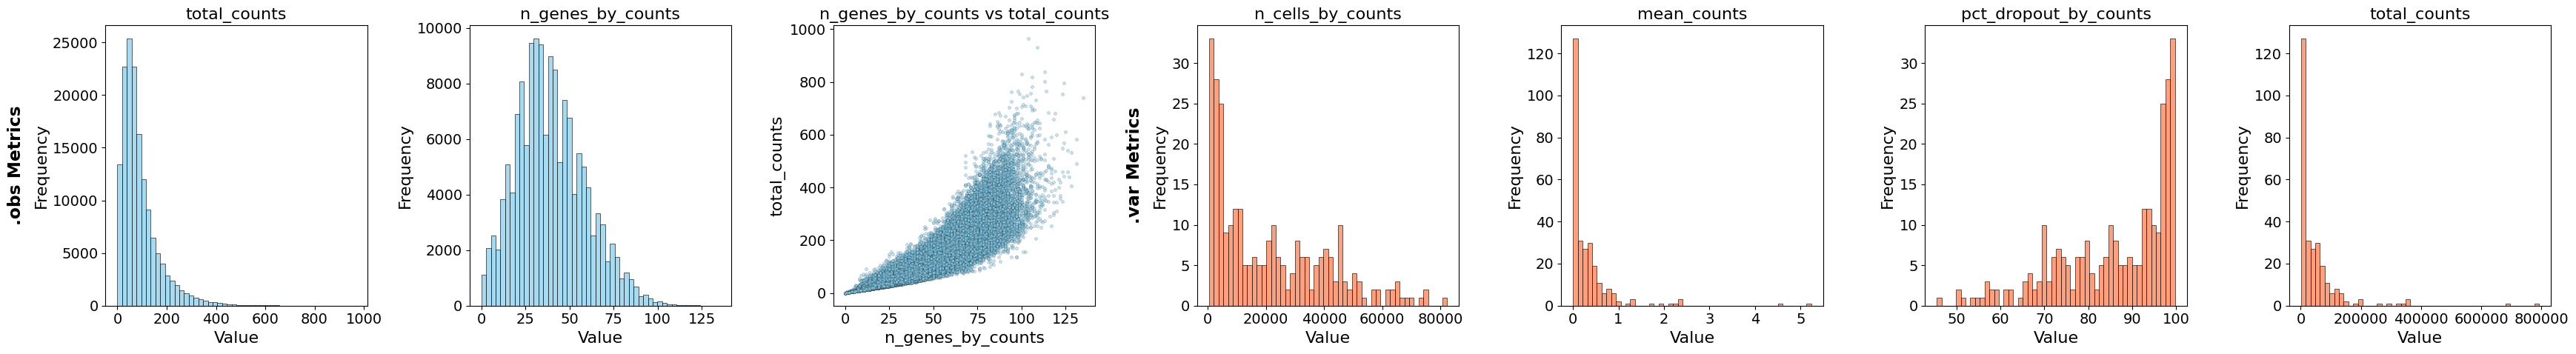

In [31]:
plot_qc_metrics(adata, show_inset=False)

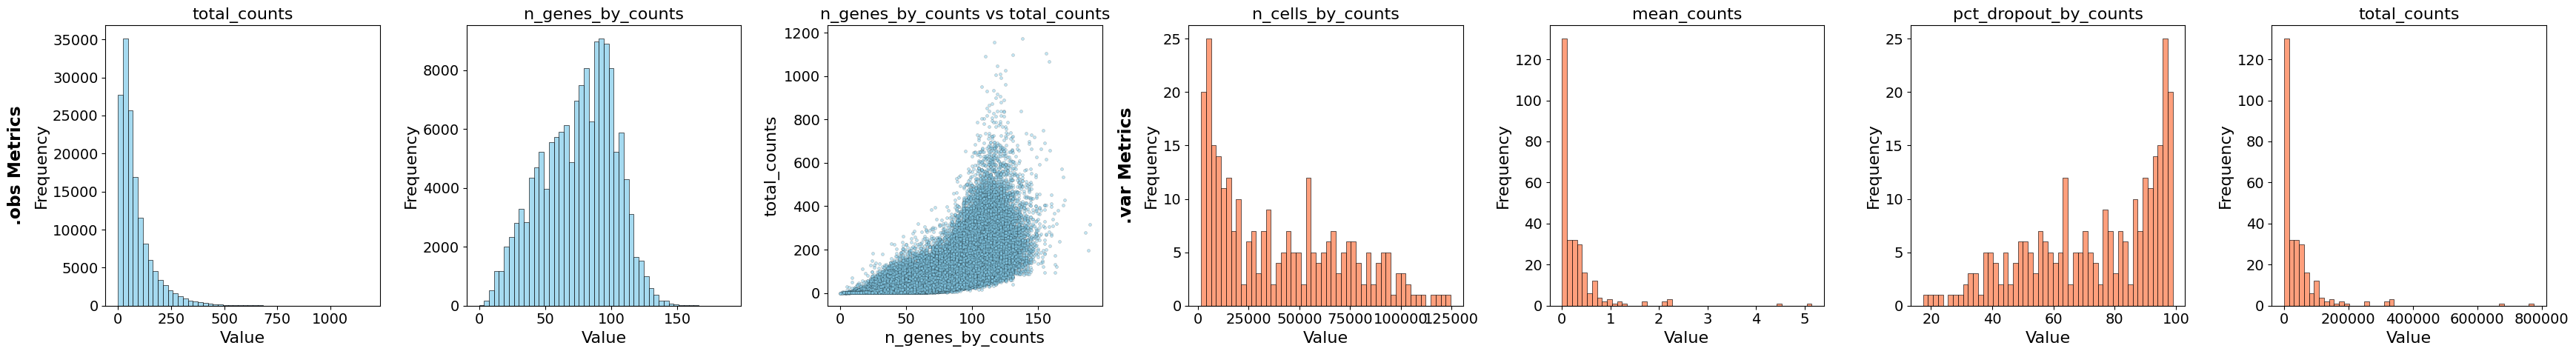

In [32]:
plot_qc_metrics(proseg_adata, show_inset=False)

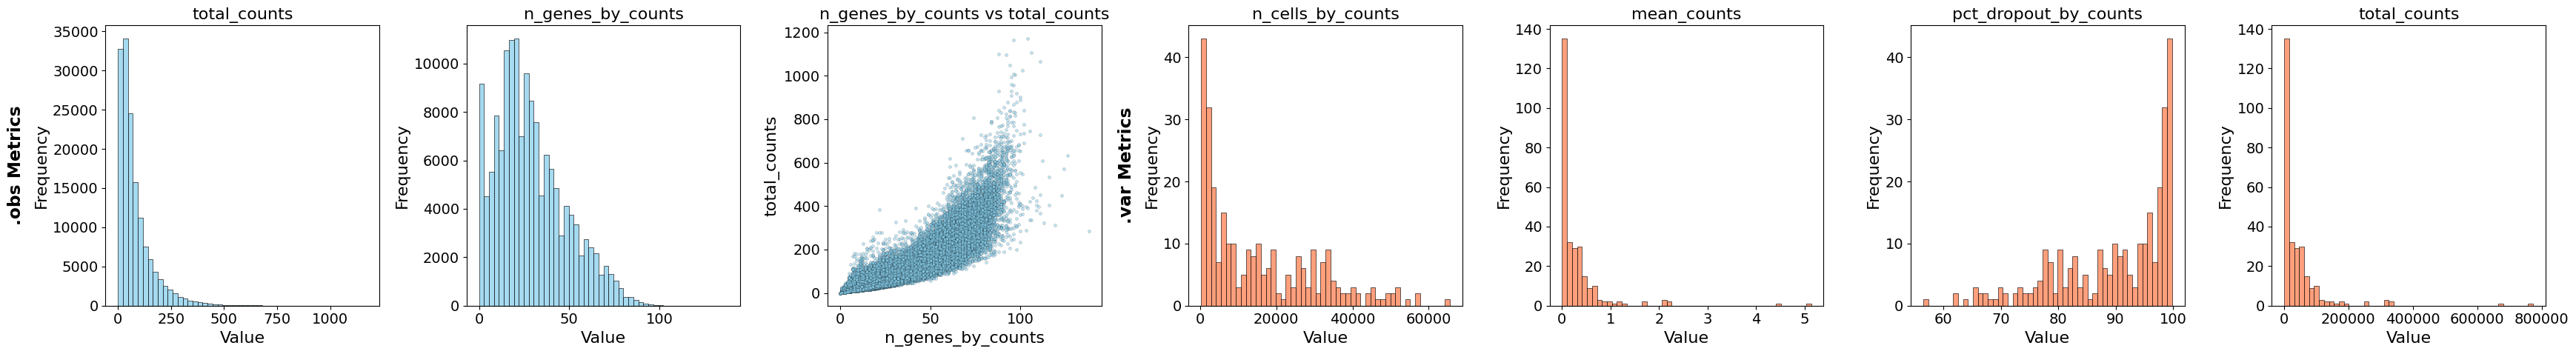

In [33]:
plot_qc_metrics(proseg_adata_rounded, show_inset=False)

### Filter proseg results by size

Here we filter out very large or very small cells.

In [50]:
upper = []
for _, xd in exp.iterdata():
    upper.append(xd.cells["proseg"].matrix.obs["volume"].quantile(0.95))
upper_size_limit = np.median(upper)

lower = []
for _, xd in exp.iterdata():
    lower.append(xd.cells["proseg"].matrix.obs["volume"].quantile(0.05))
lower_size_limit = np.median(lower)

In [52]:
print(upper_size_limit)
print(lower_size_limit)

1887.8148
213.38353


In [65]:
for _, xd in exp.iterdata():
    adata = xd.cells["proseg"].matrix
    mask1 = adata.obs["volume"] > lower_size_limit
    mask2 = adata.obs["volume"] < upper_size_limit
    xd.cells["proseg"].matrix = adata[mask1 & mask2].copy()
    xd.cells.sync()

In [66]:
exp.show(0)

Viewer(camera=Camera(center=(0.0, 2906.04375, 3627.1625), zoom=0.04717991934234437, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 5812.299999999999, 0.2125), (0.0, 7254.537499999999, 0.2125)), current_step=(13675, 17069), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x2619f9f3280>, <Image layer 'HE' at 0x2619f920670>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='0003621: Region_1-1414_18_IIA', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x0000026198B59940>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

## Calculate QC metrics

### For `"main"` layer

In [68]:
calculate_qc_metrics(
    data=exp, cells_layer=None, percent_top=None, log1p=False
)

7it [00:01,  5.02it/s]


### For `"proseg"` layer

In [69]:
calculate_qc_metrics(
    data=exp, cells_layer='proseg', percent_top=None, log1p=False
)

7it [00:01,  4.82it/s]


## Filter by counts

In [71]:
exp.data[0].cells.matrix

AnnData object with n_obs × n_vars = 151305 × 280
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'

In [72]:
exp.data[0].cells["proseg"].matrix

AnnData object with n_obs × n_vars = 129751 × 280
    obs: 'original_cell_id', 'centroid_x', 'centroid_y', 'centroid_z', 'fov', 'cluster', 'volume', 'scale', 'population', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'
    layers: 'counts_rounded'

0-main


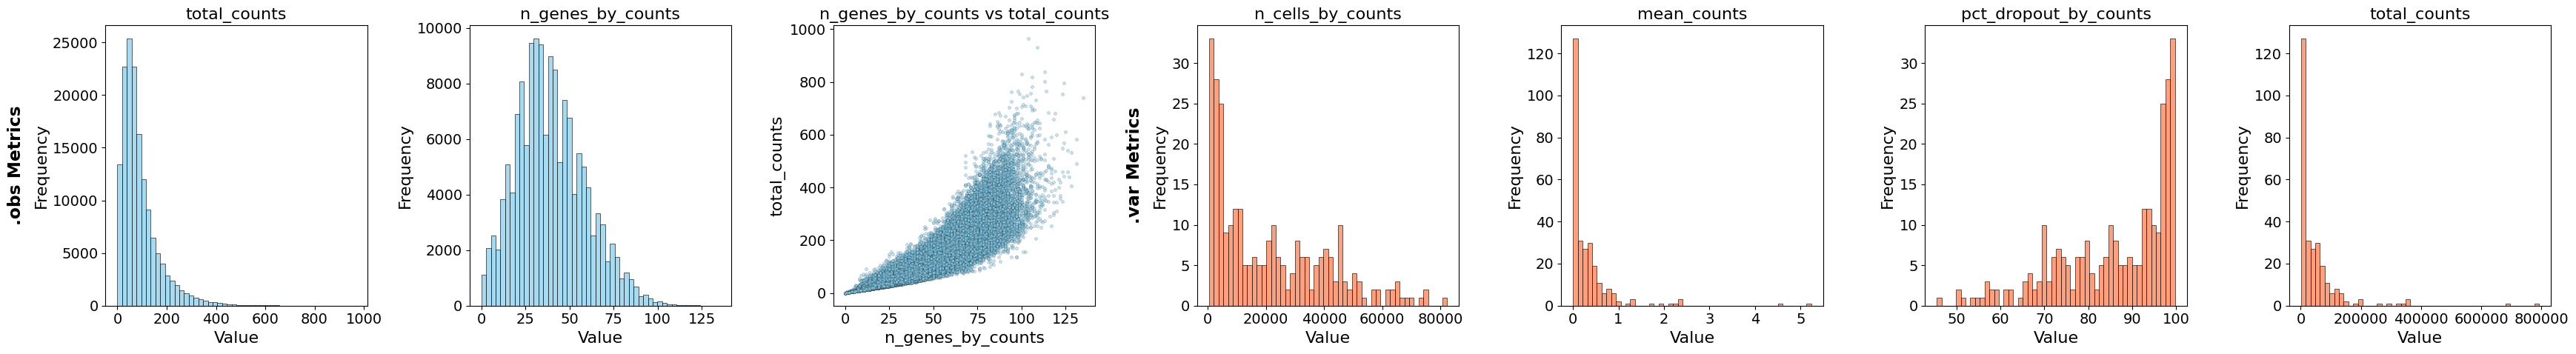

0-proseg


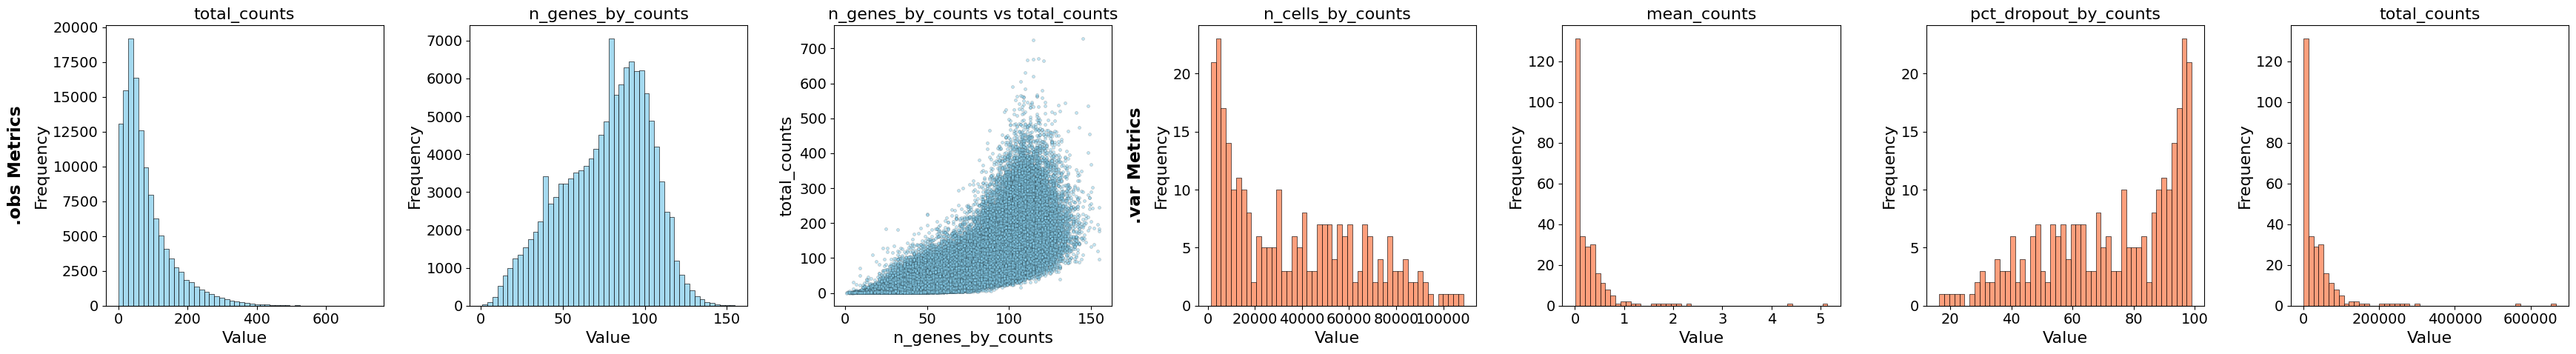

1-main


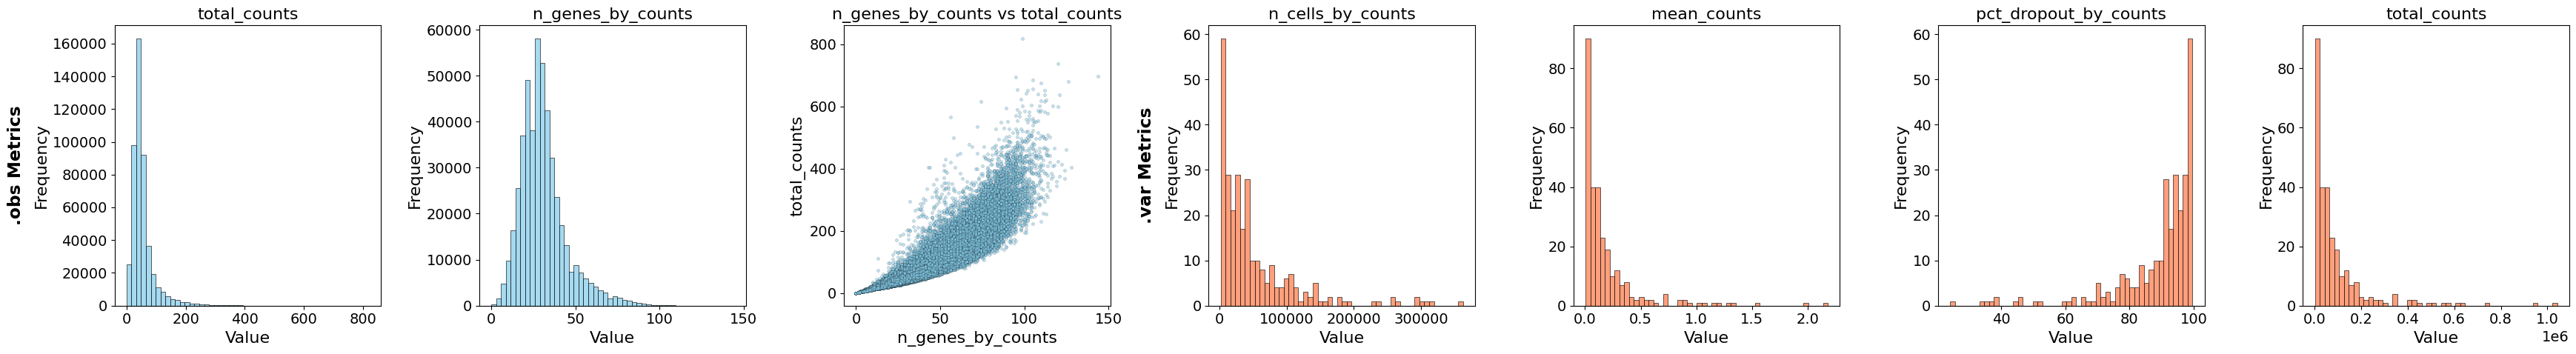

1-proseg


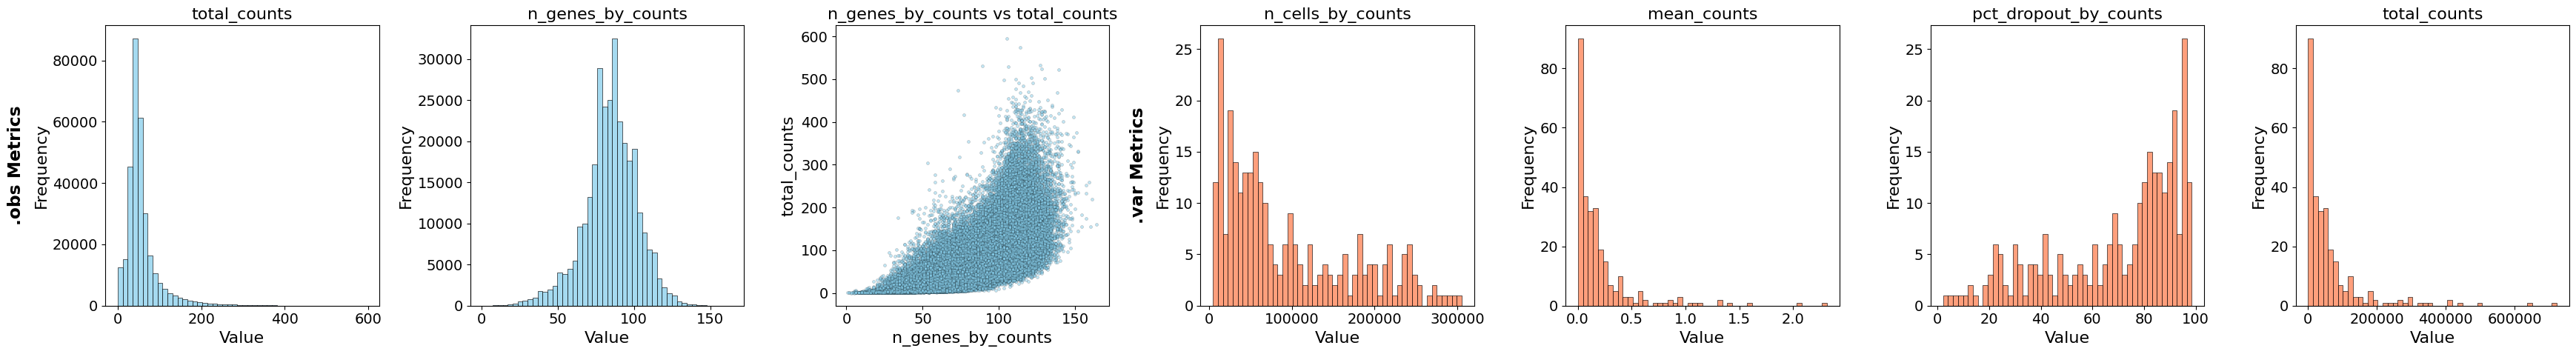

2-main


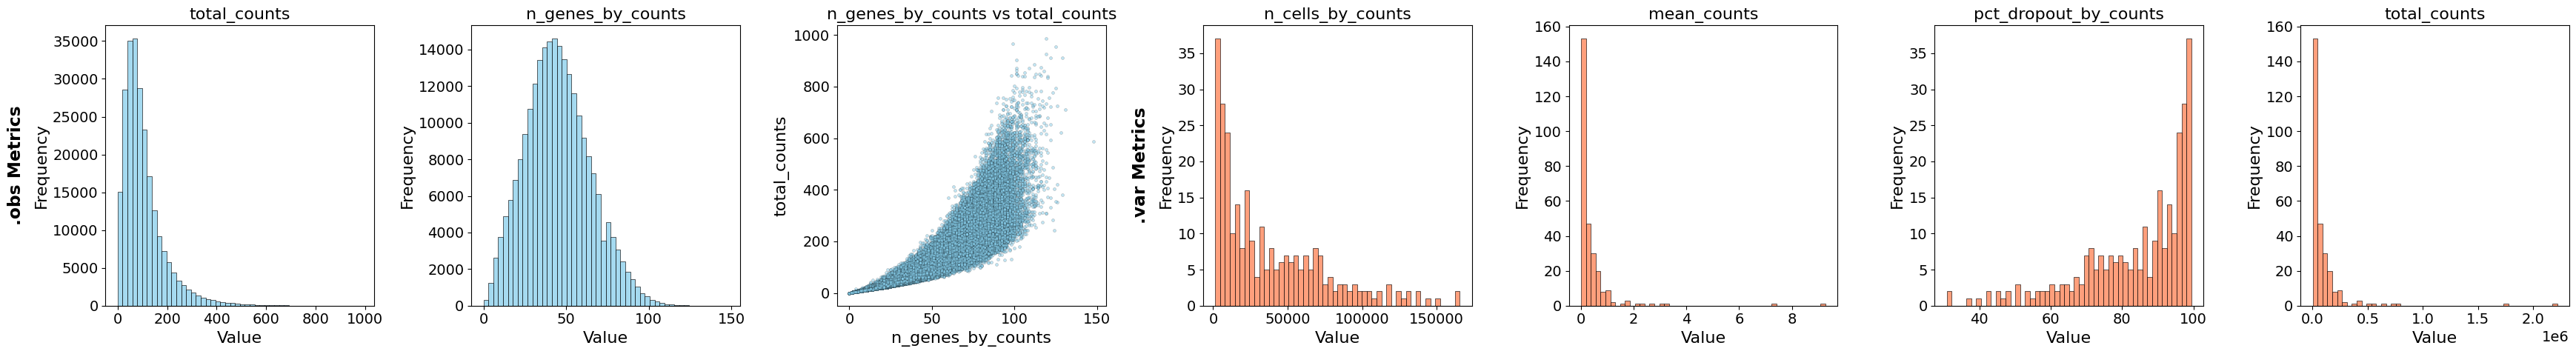

2-proseg


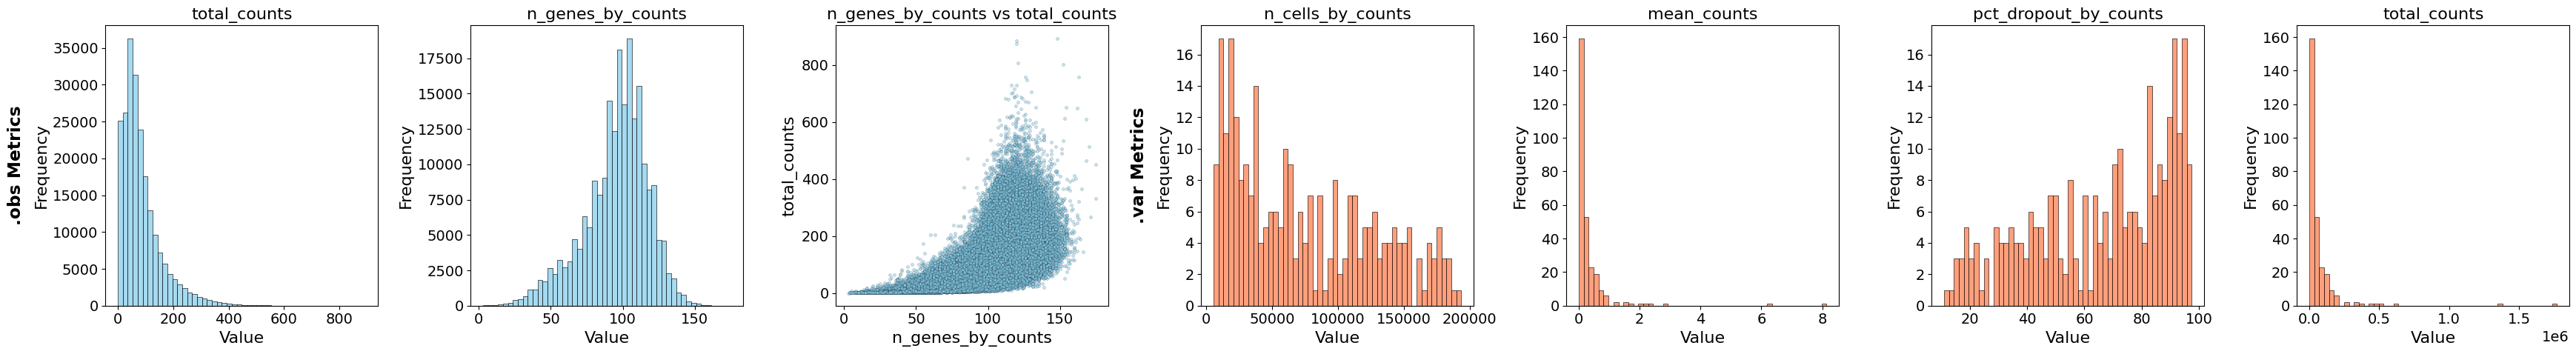

3-main


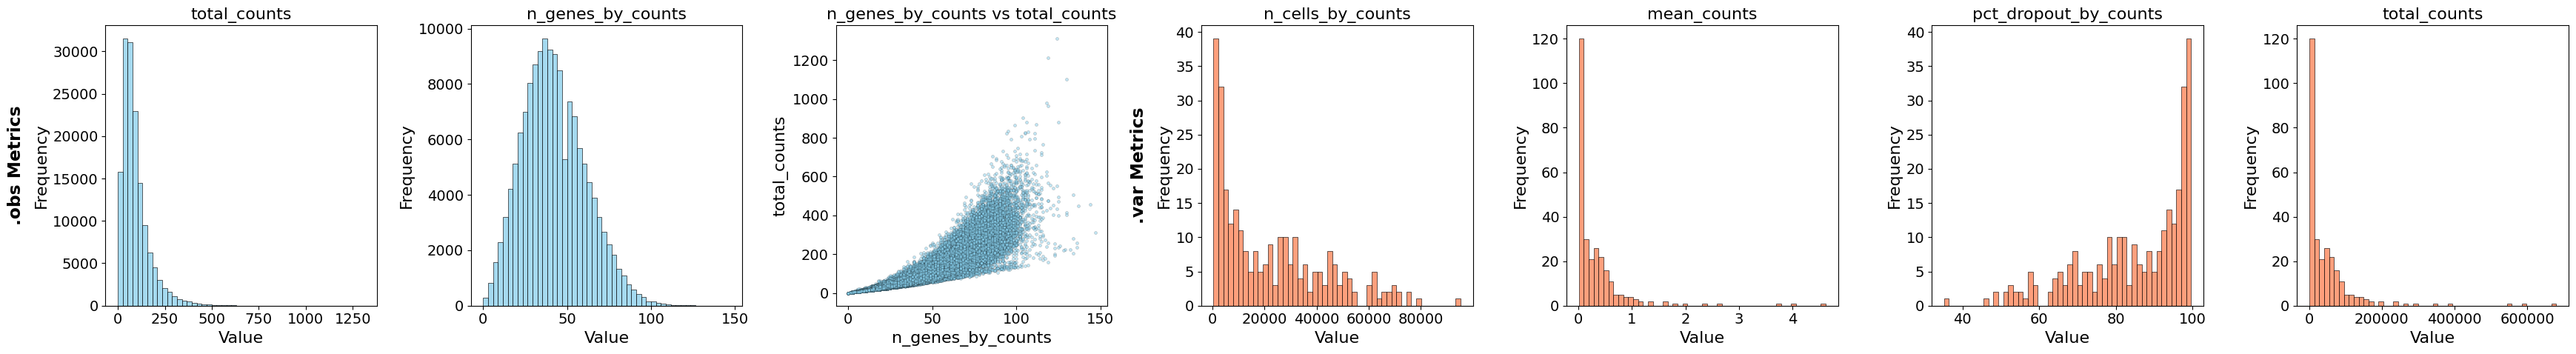

3-proseg


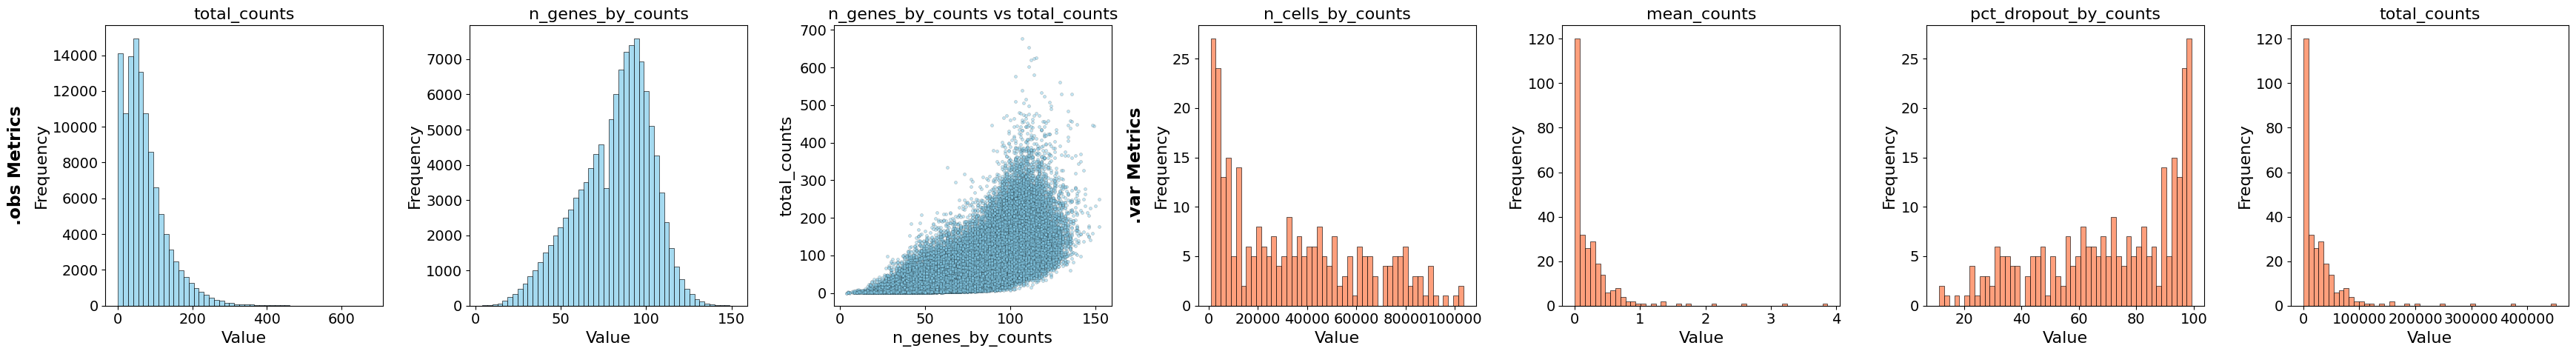

4-main


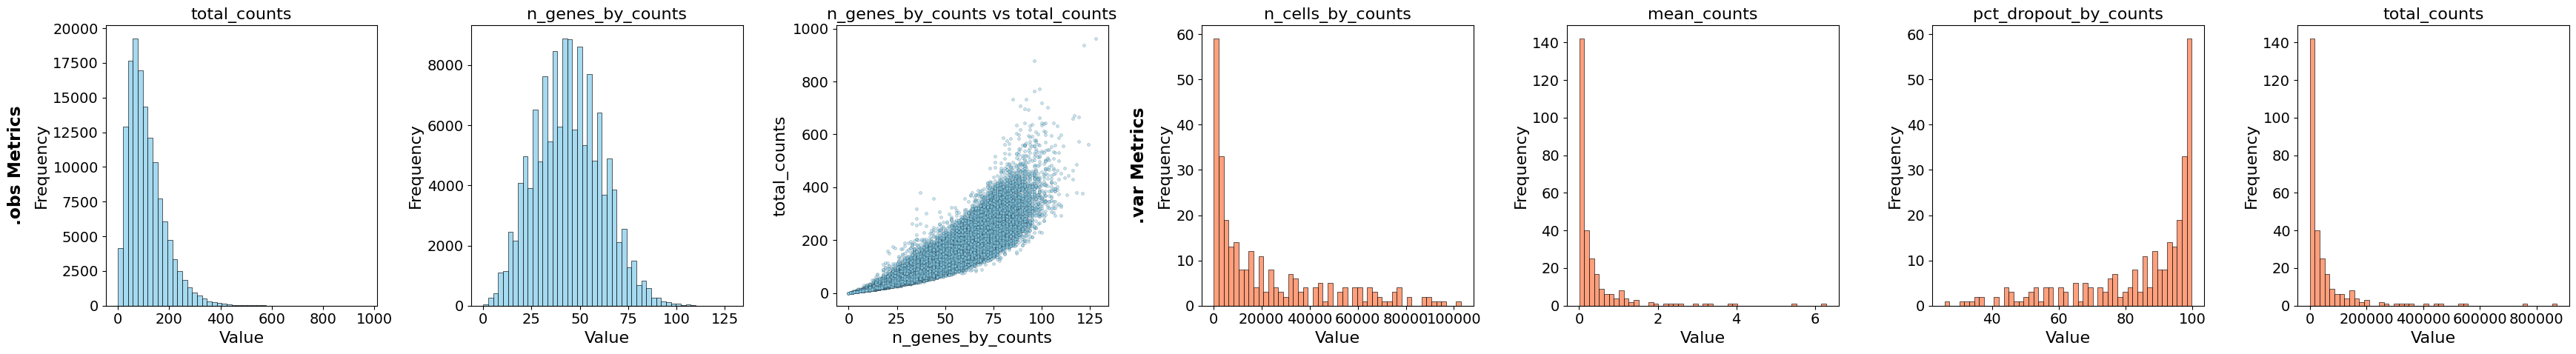

4-proseg


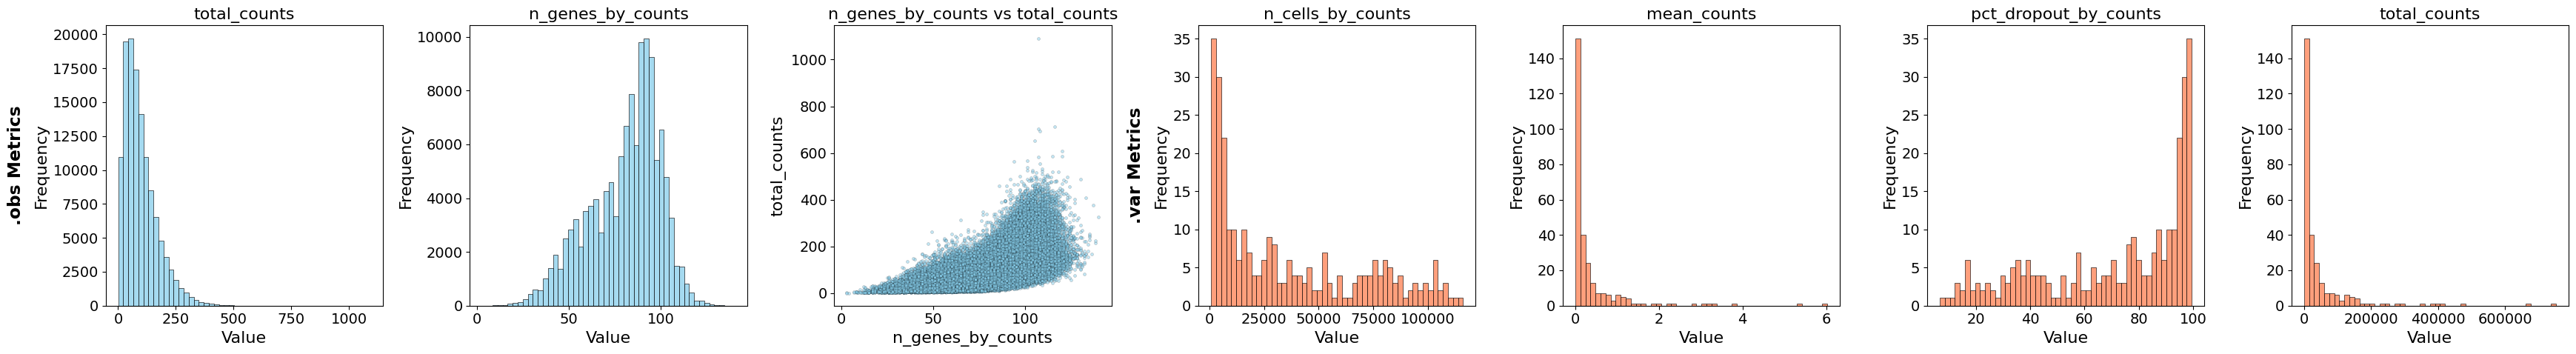

5-main


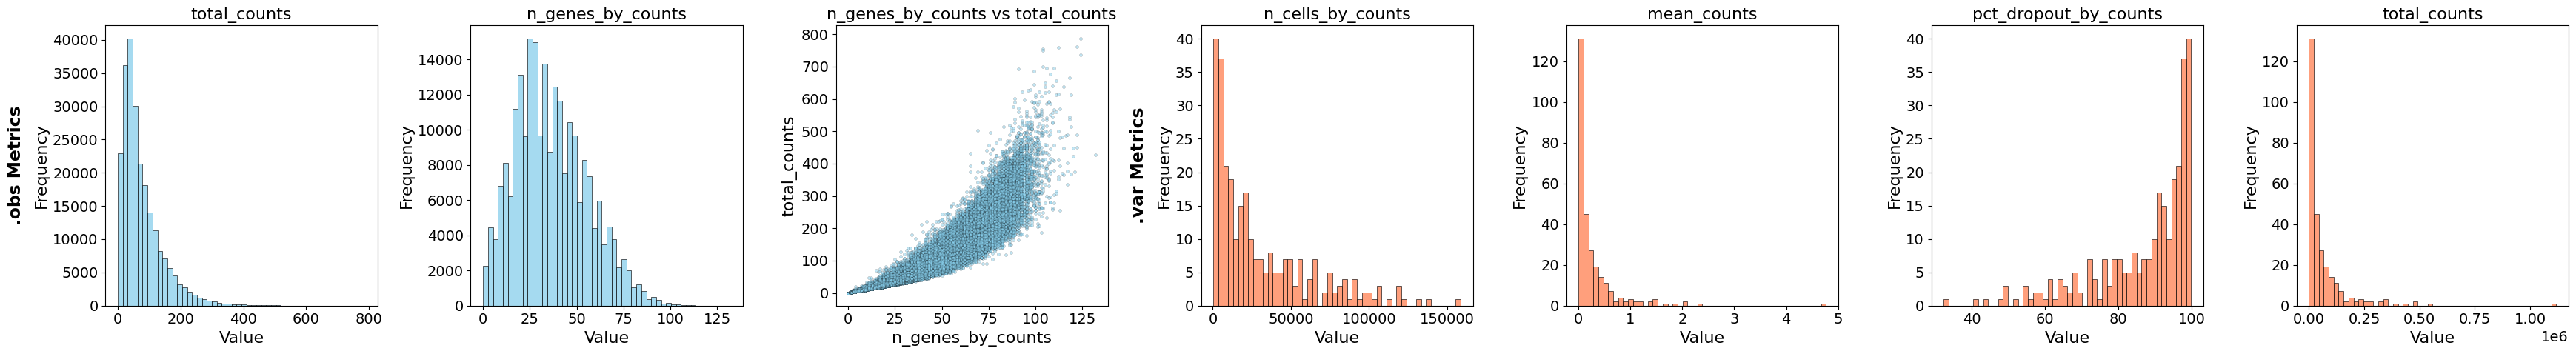

5-proseg


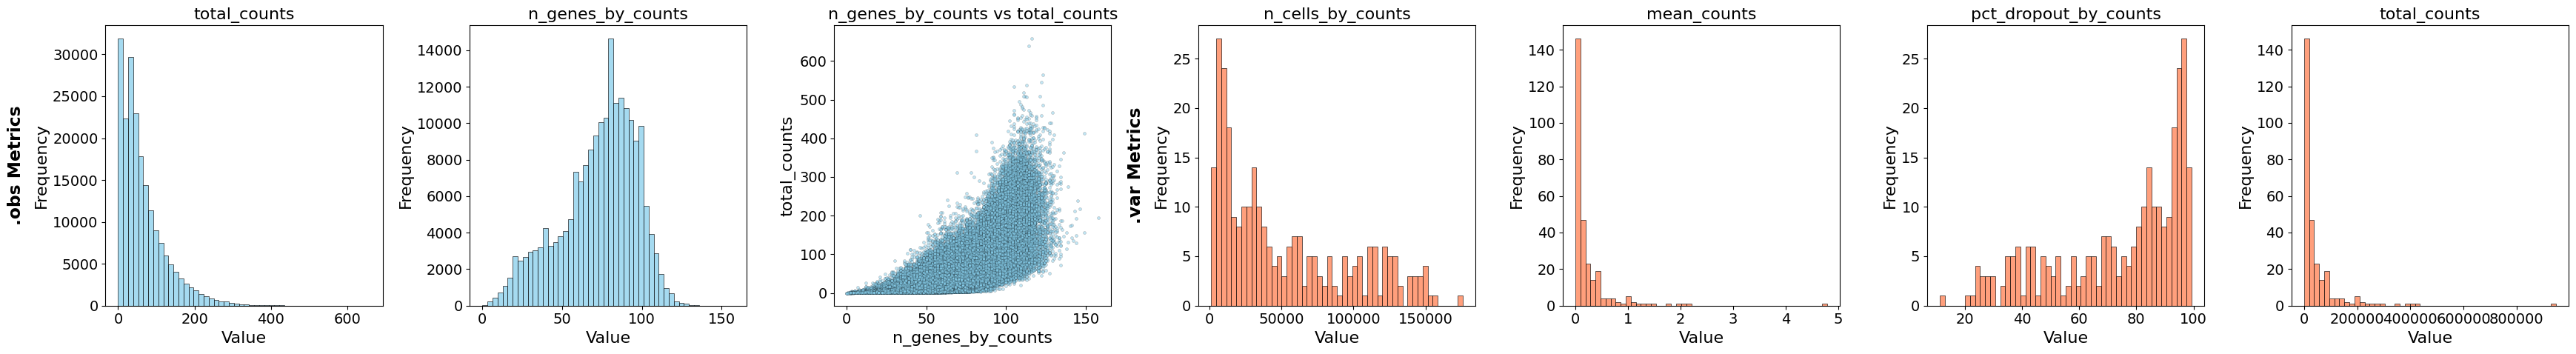

6-main


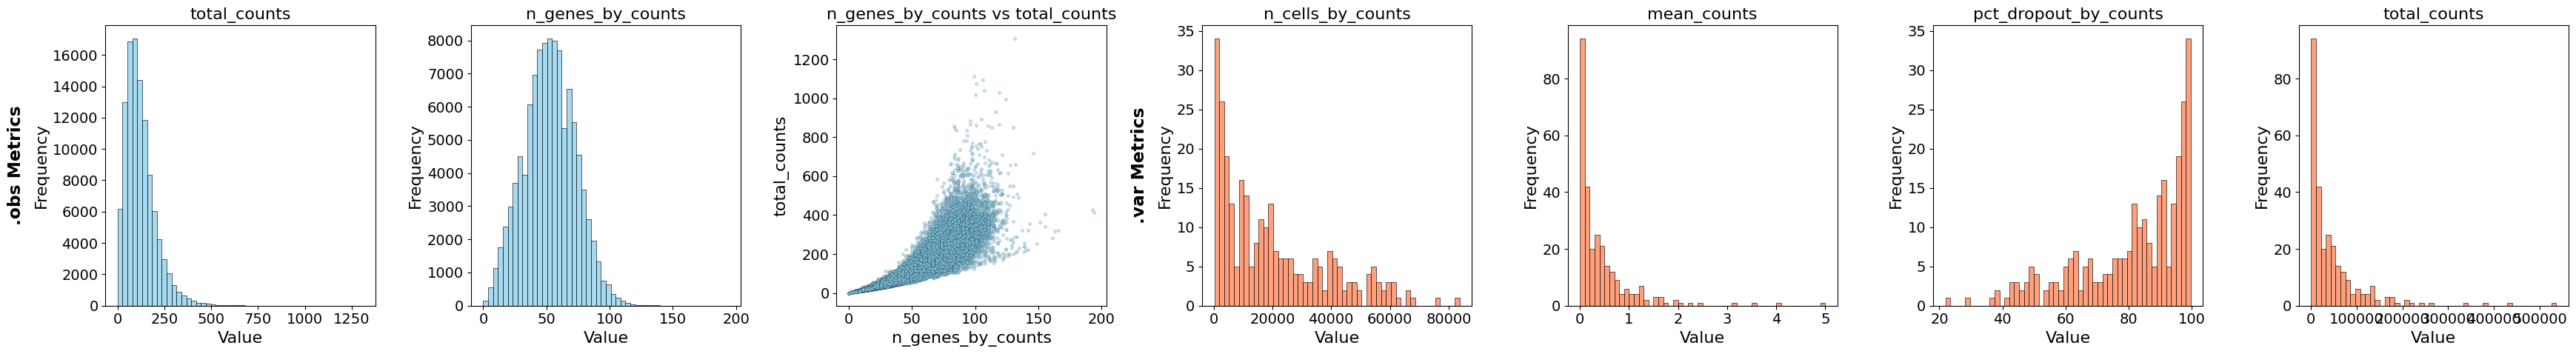

6-proseg


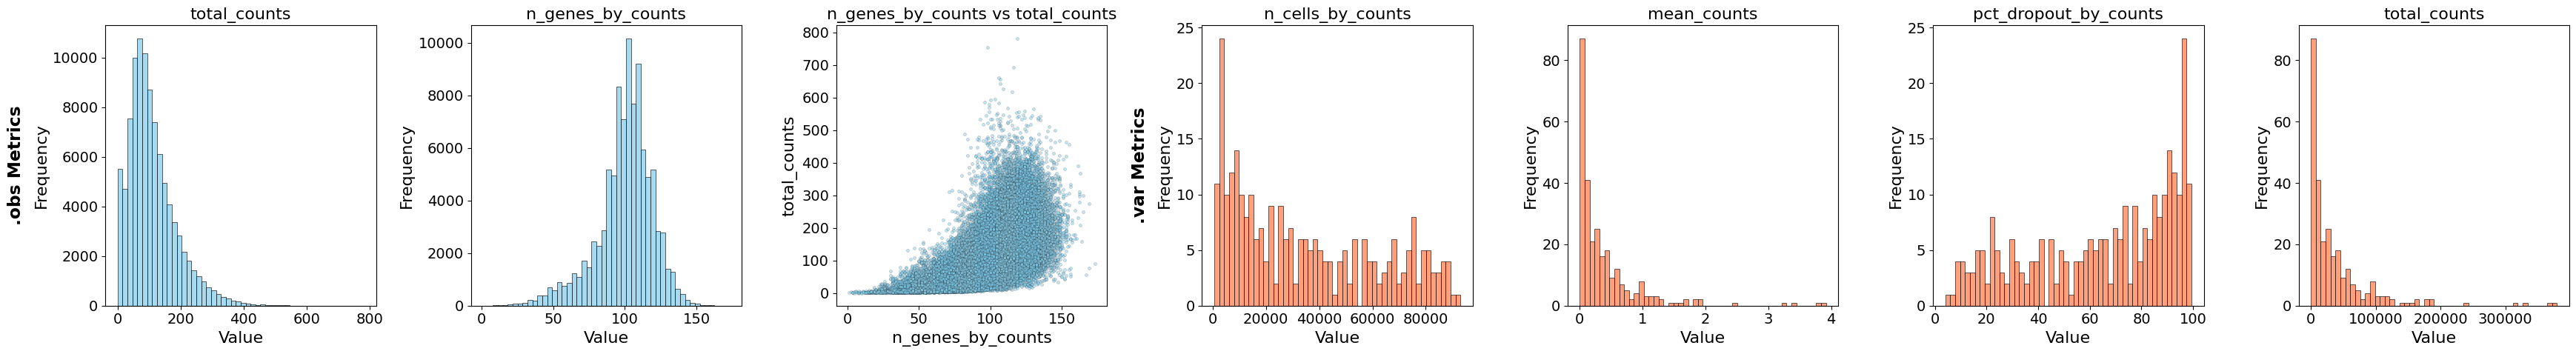

In [70]:
for meta, data in exp.iterdata():
    for k in cell_keys:
        print(f"{meta.name}-{k}")
        plot_qc_metrics(data, cells_layer=k)

### Do the filtering on cell level

In [25]:
from insitupy.preprocessing import filter_cells

First on the main data:

In [75]:
filter_cells(
    data=exp,
    cells_layer="main",
    min_counts=50
    #min_genes=thresholds["main"]
)

7it [00:03,  2.16it/s]


In [76]:
filter_cells(
    data=exp,
    cells_layer="main",
    min_genes=50
    #min_genes=thresholds["main"]
)

7it [00:02,  3.26it/s]


Then on the `"proseg"` data:

In [77]:
filter_cells(
    data=exp,
    cells_layer="proseg",
    min_counts=50
    #min_genes=thresholds["proseg"]
)

7it [00:03,  2.03it/s]


In [78]:
filter_cells(
    data=exp,
    cells_layer="proseg",
    min_genes=50,
    #min_genes=thresholds["proseg"]
)

7it [00:03,  2.23it/s]


## Recalculate QC metrics to update var metrics

In [79]:
calculate_qc_metrics(
    data=exp, cells_layer="main", percent_top=None, log1p=False
)

7it [00:00, 13.46it/s]


In [80]:
calculate_qc_metrics(
    data=exp, cells_layer='proseg', percent_top=None, log1p=False
)

7it [00:00,  7.37it/s]


0-main


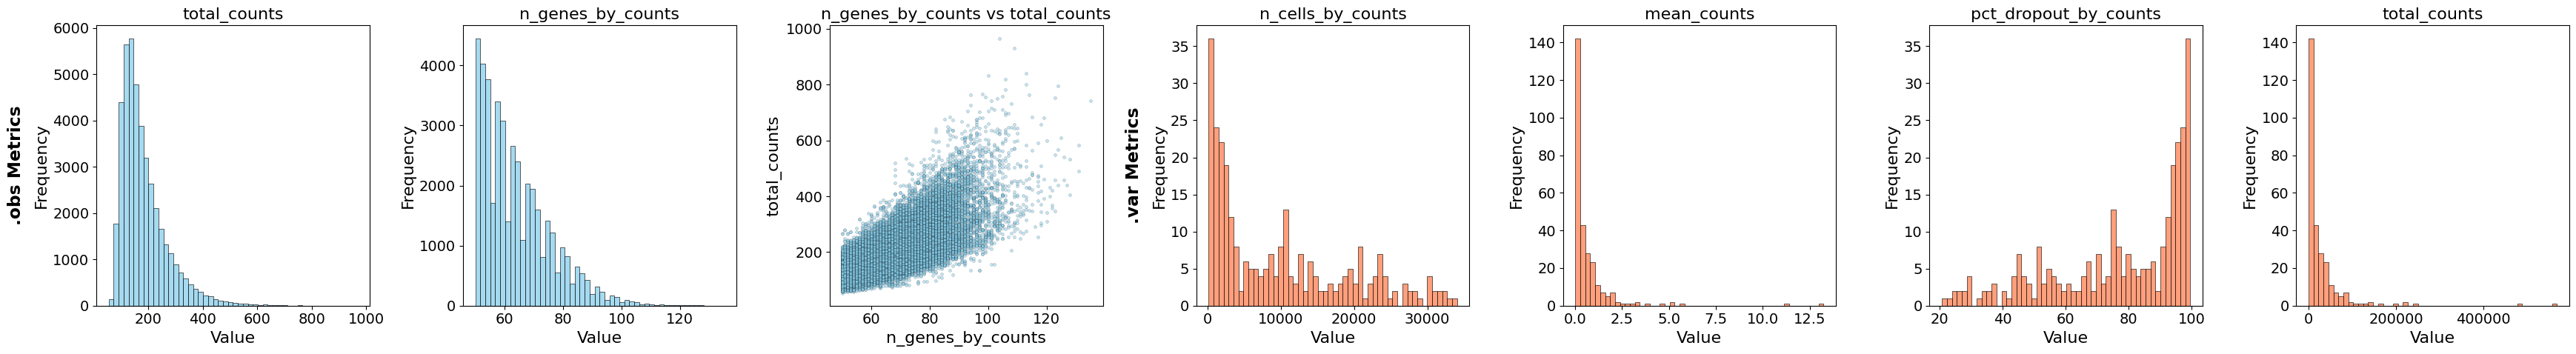

0-proseg


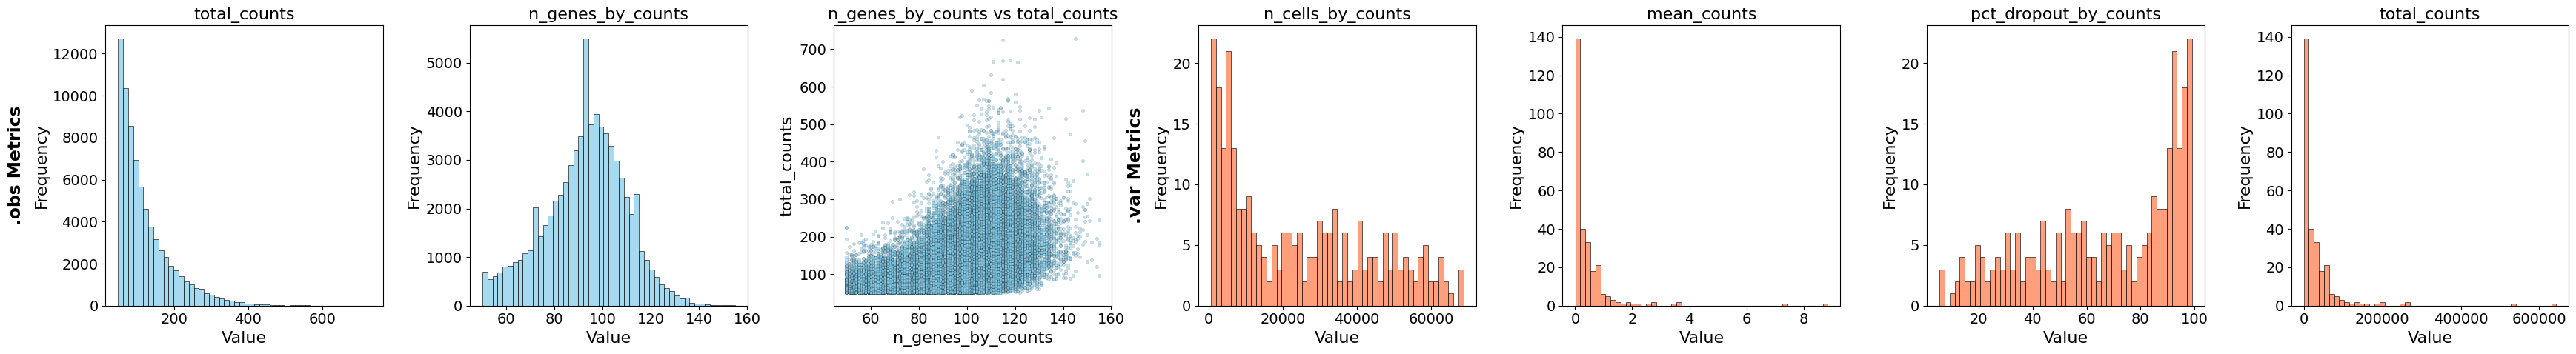

1-main


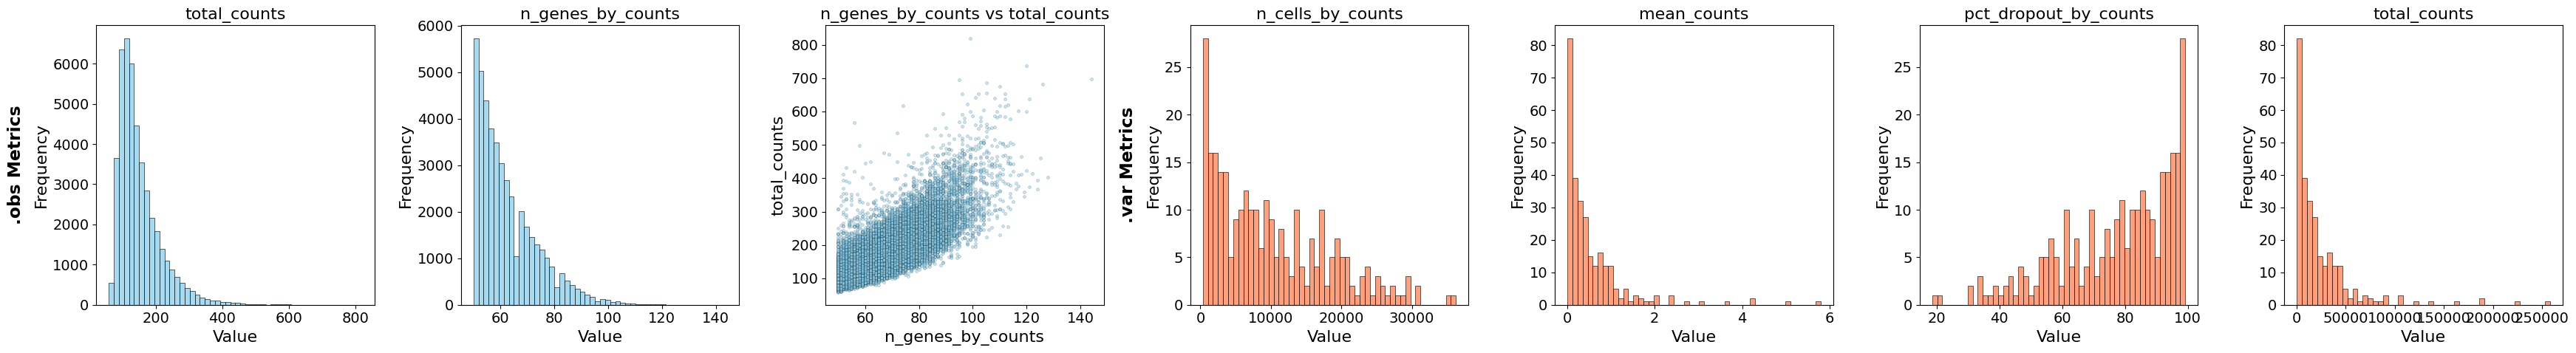

1-proseg


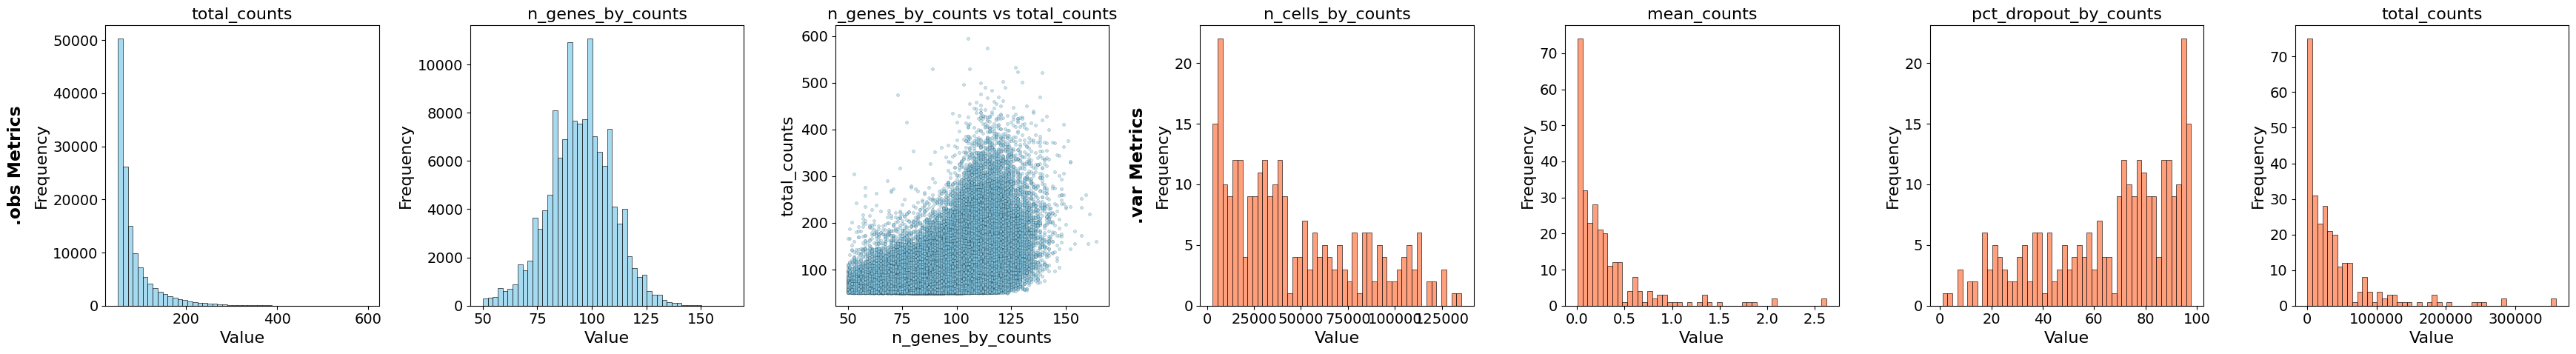

2-main


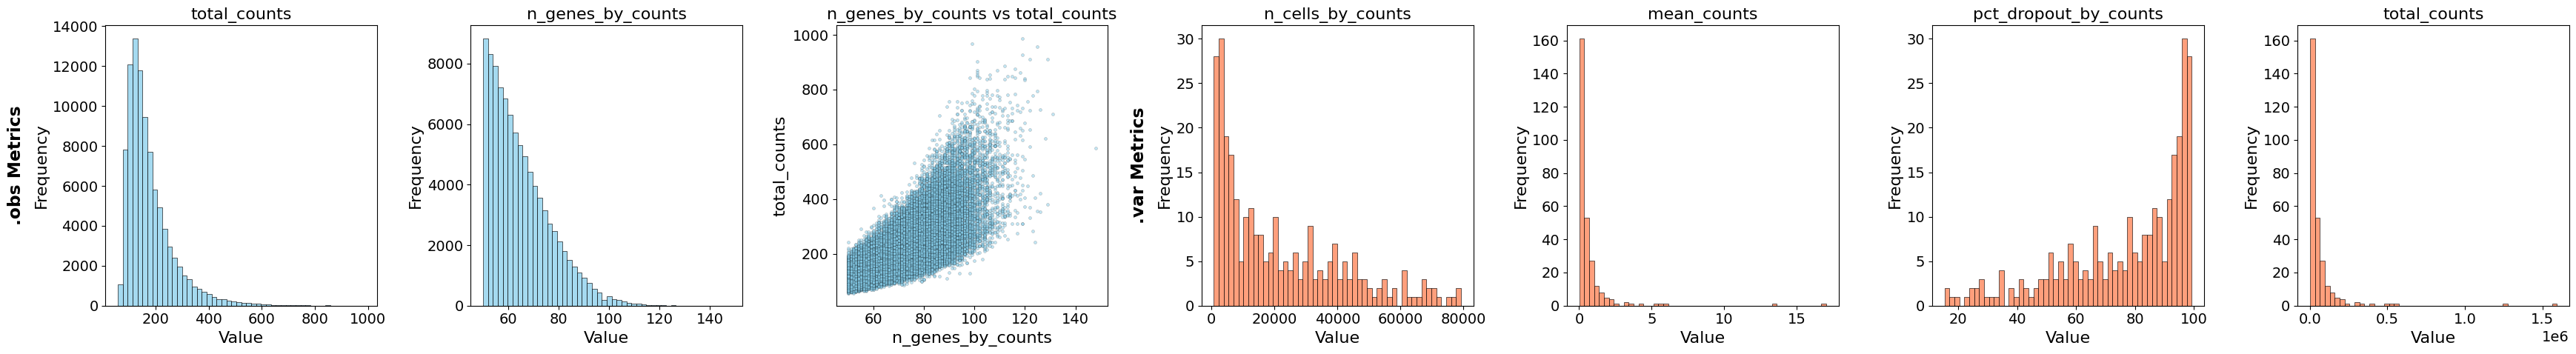

2-proseg


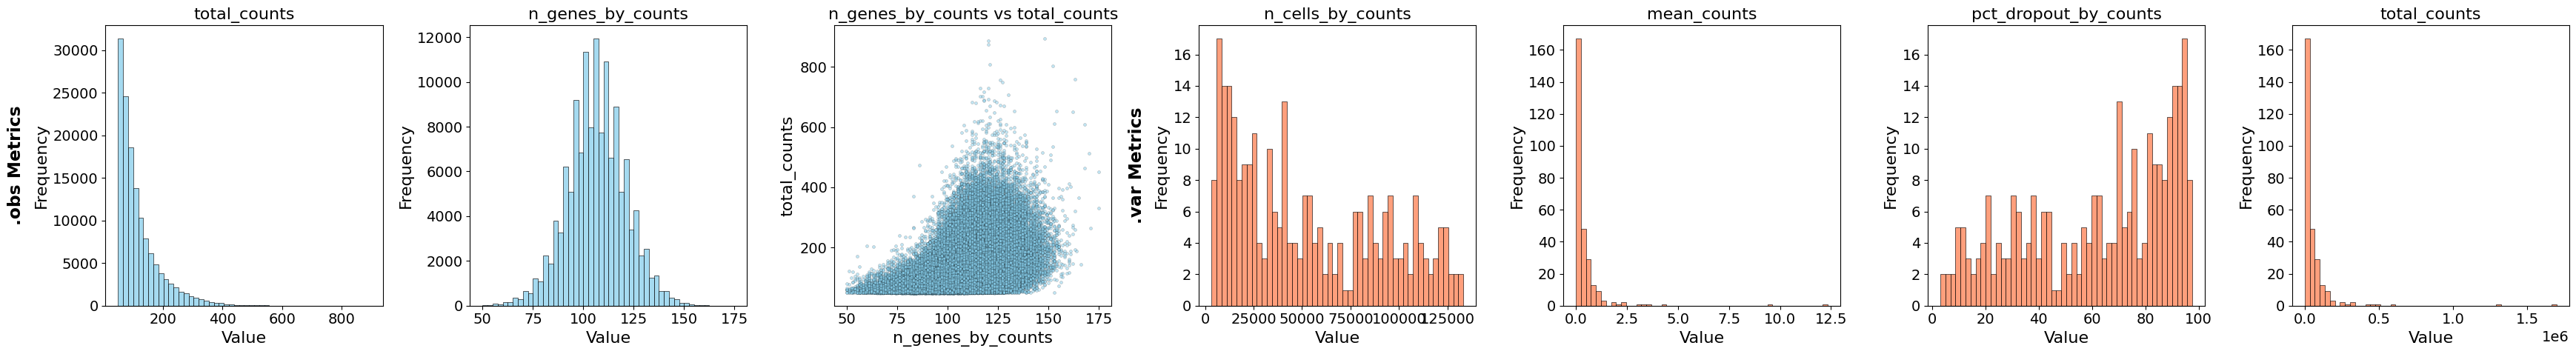

3-main


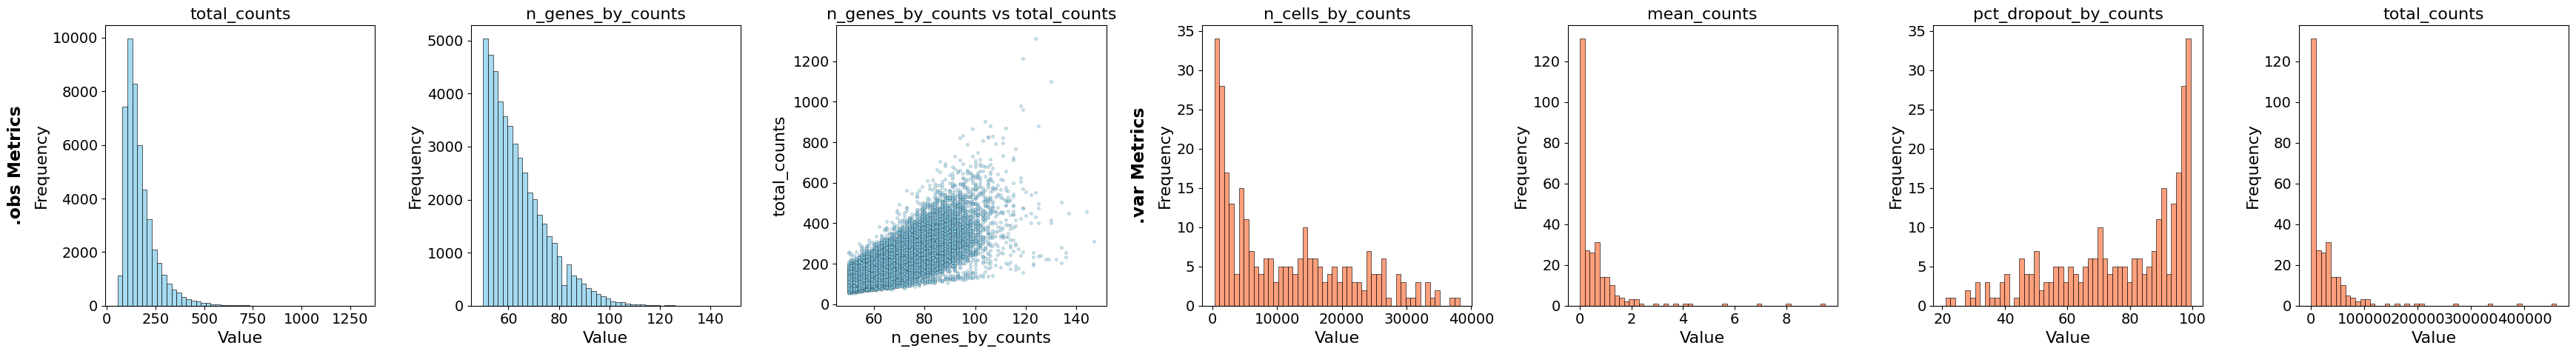

3-proseg


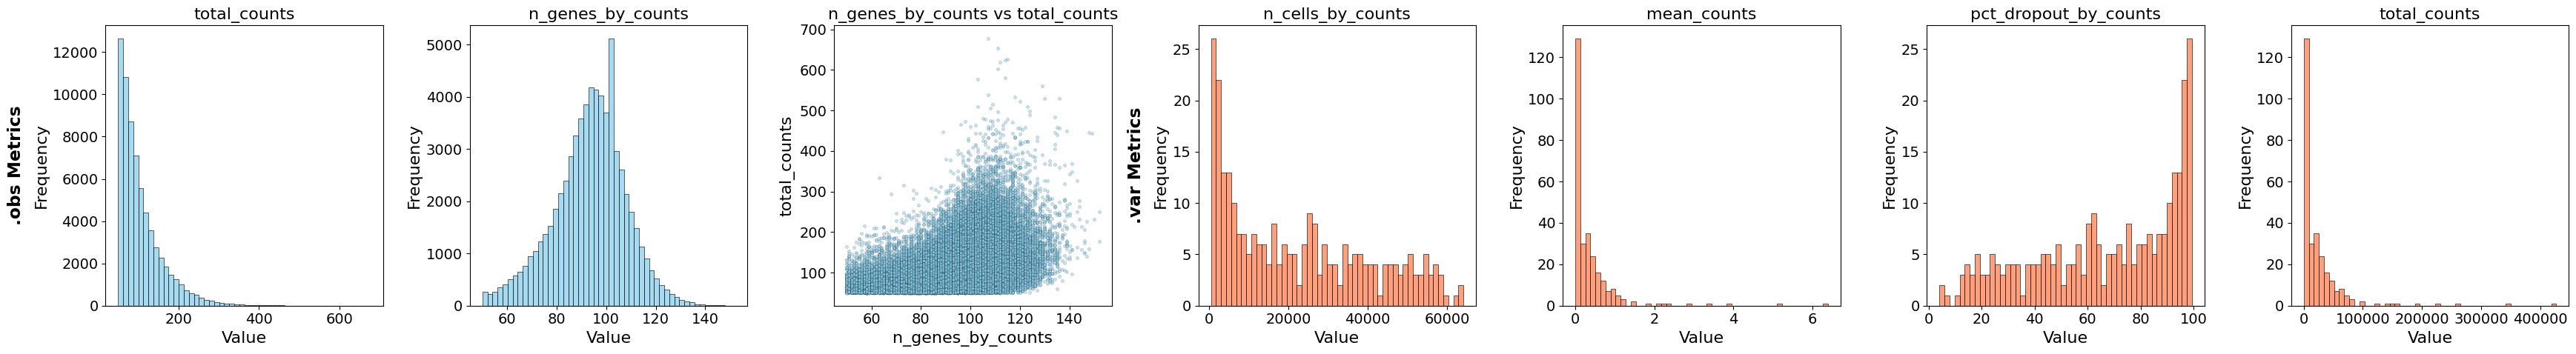

4-main


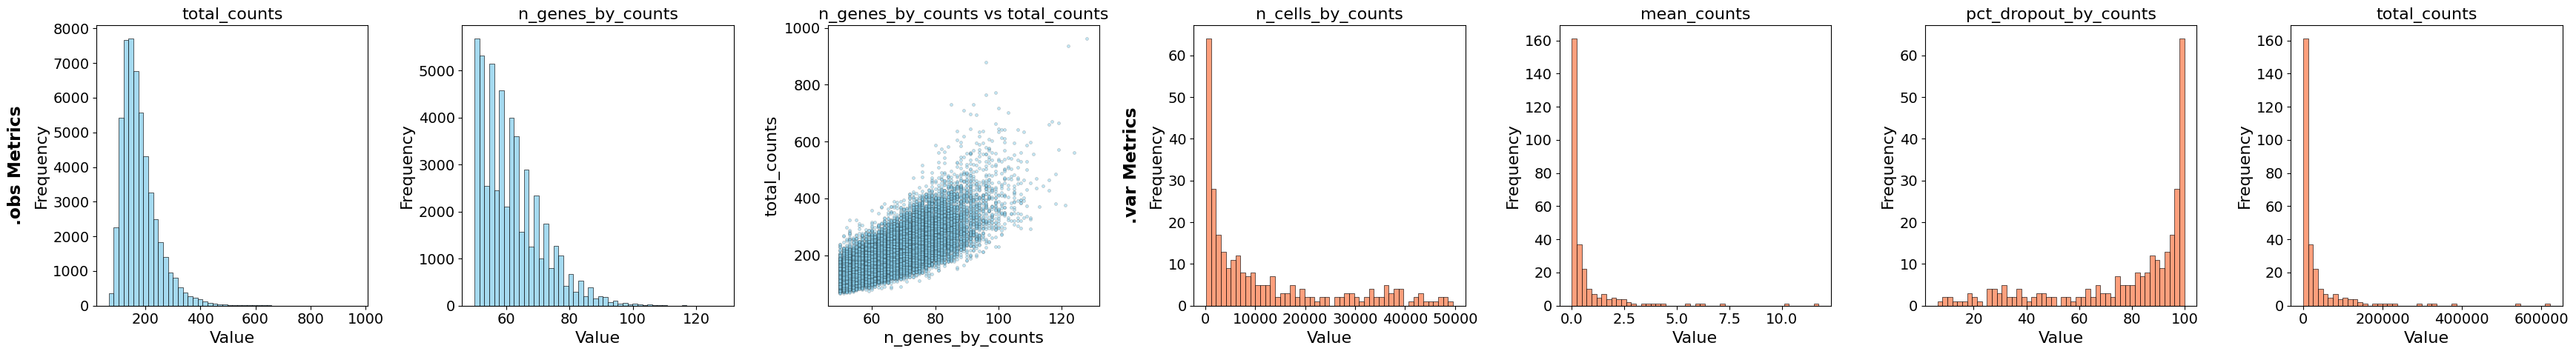

4-proseg


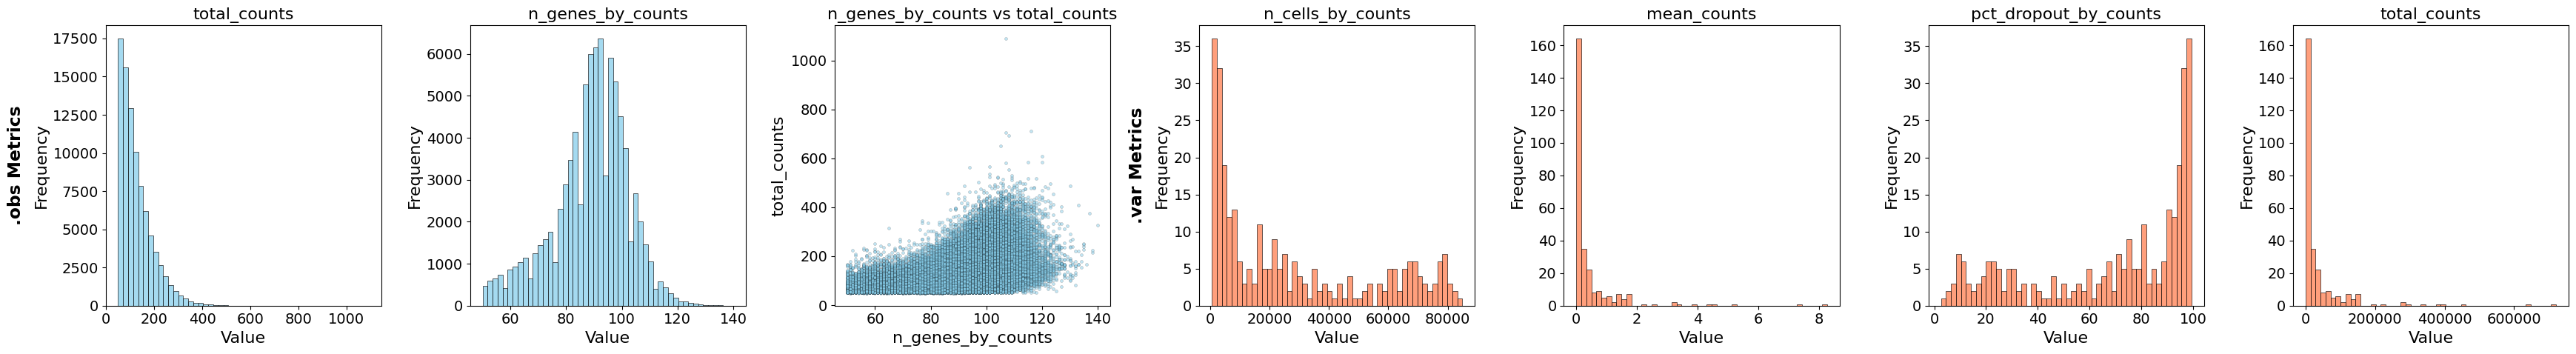

5-main


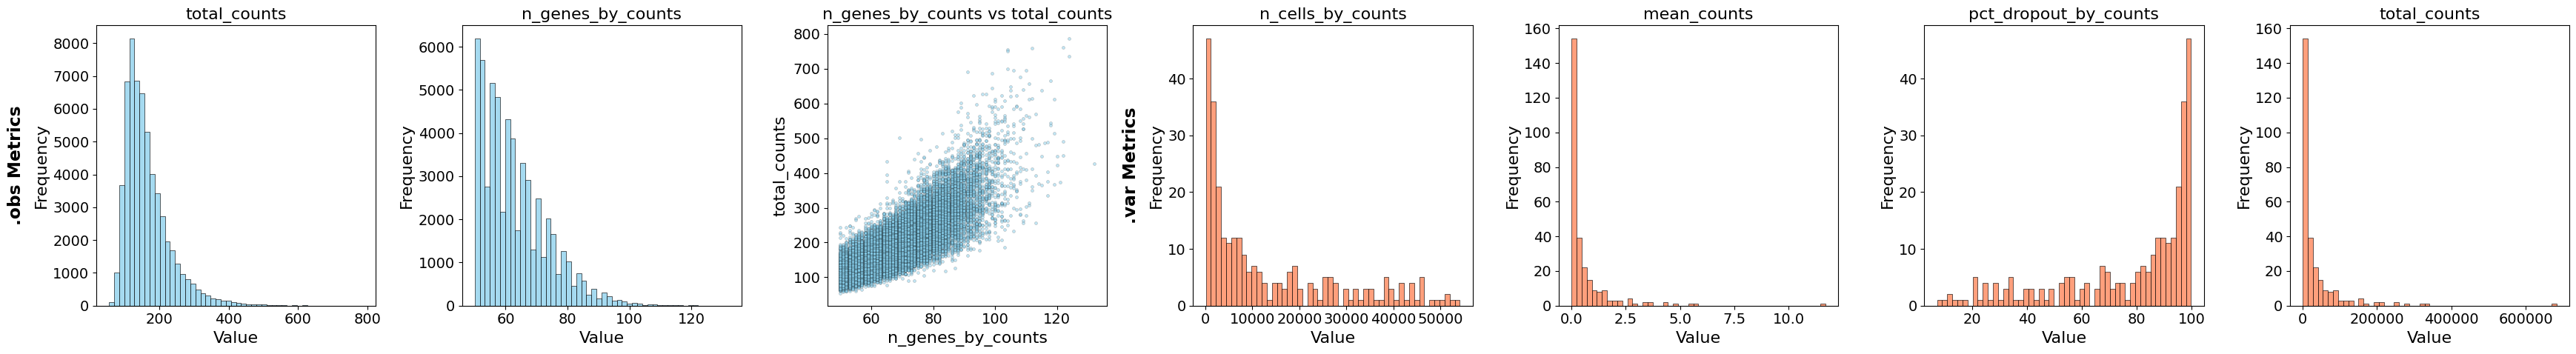

5-proseg


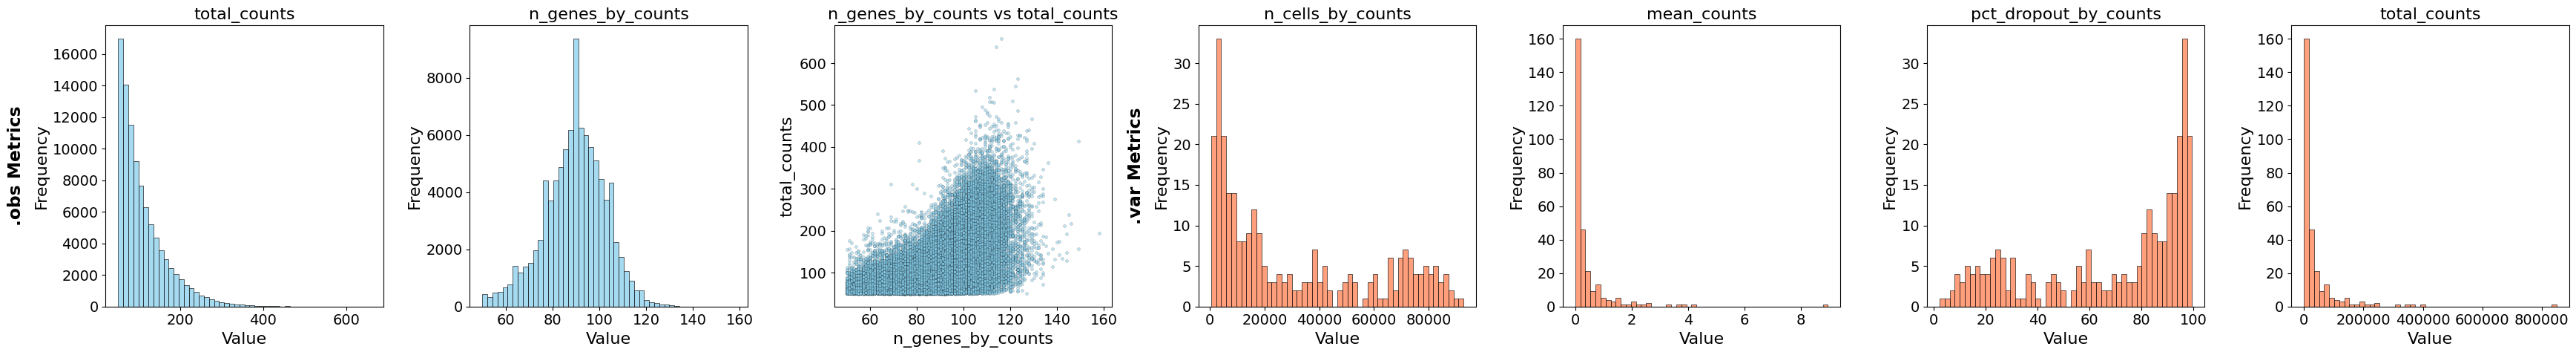

6-main


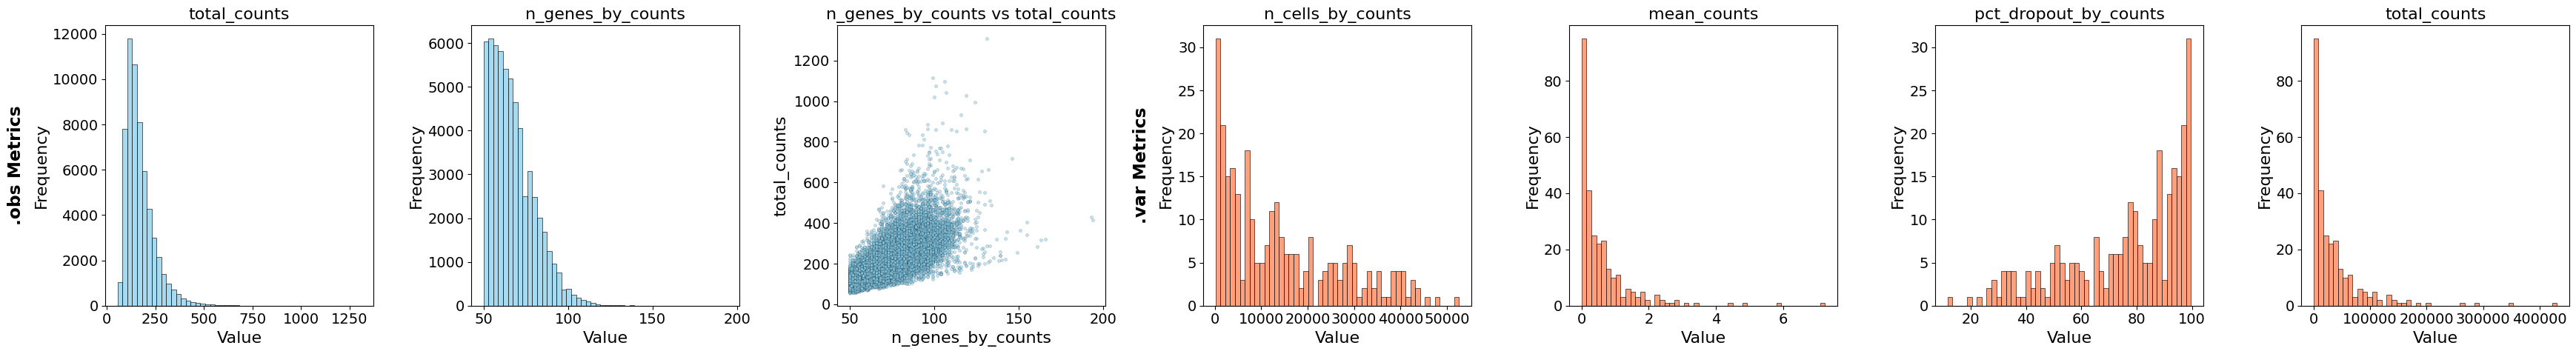

6-proseg


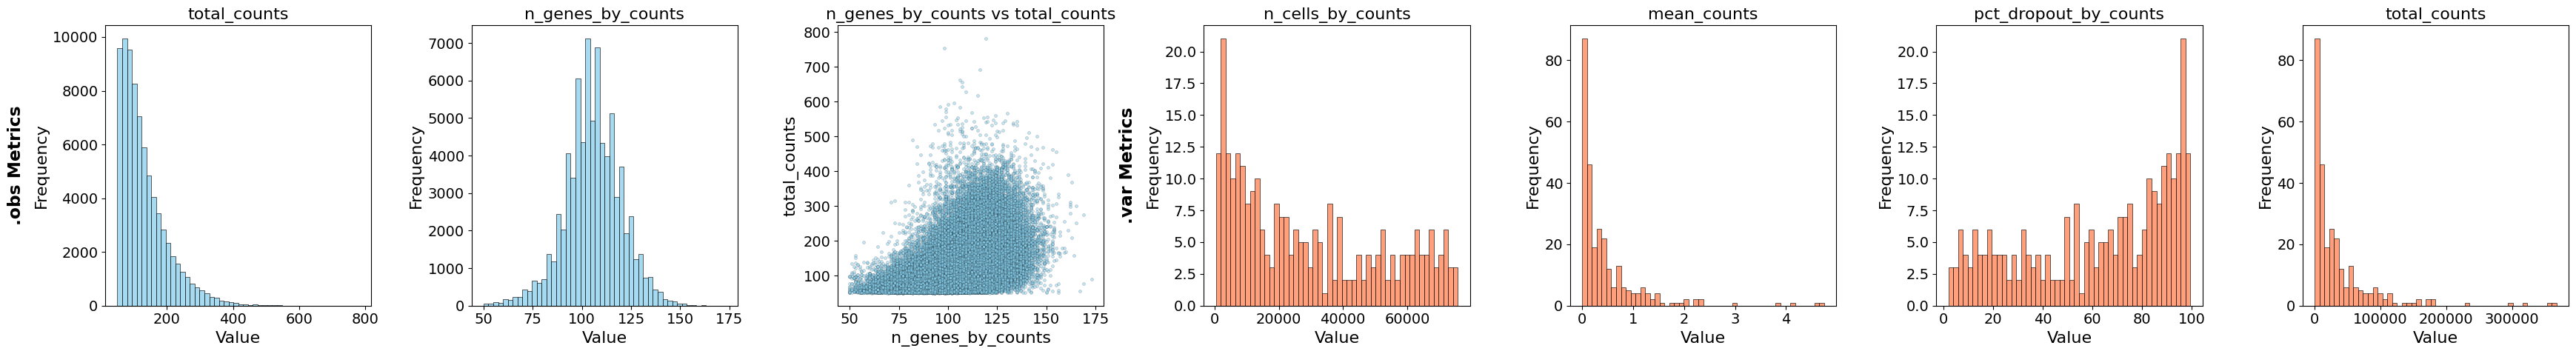

In [81]:
for meta, data in exp.iterdata():
    for k in cell_keys:
        print(f"{meta.name}-{k}")
        plot_qc_metrics(data, cells_layer=k)

## Normalization and transformation

In [82]:
from insitupy.plotting import test_transformations

0-main-without scaling


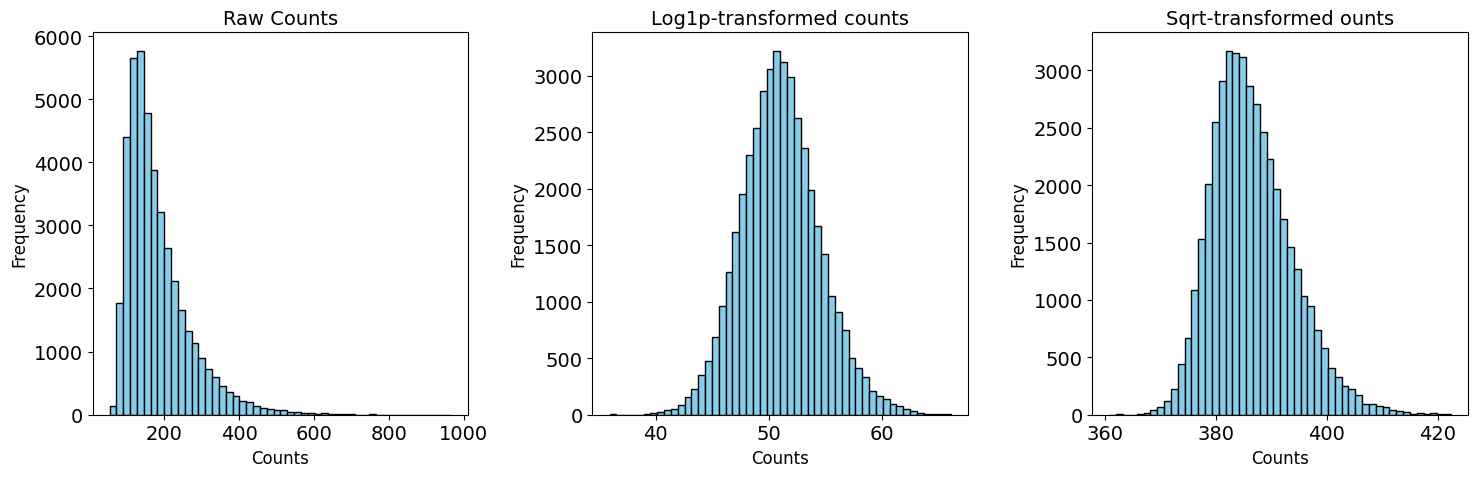

0-main-with scaling


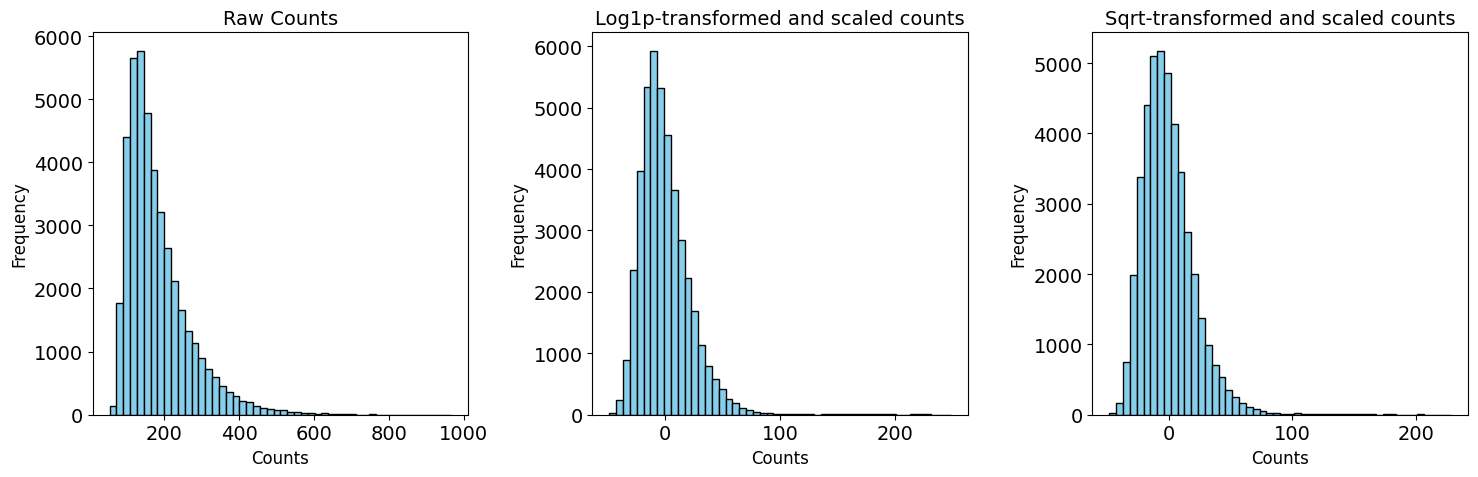

0-proseg-without scaling


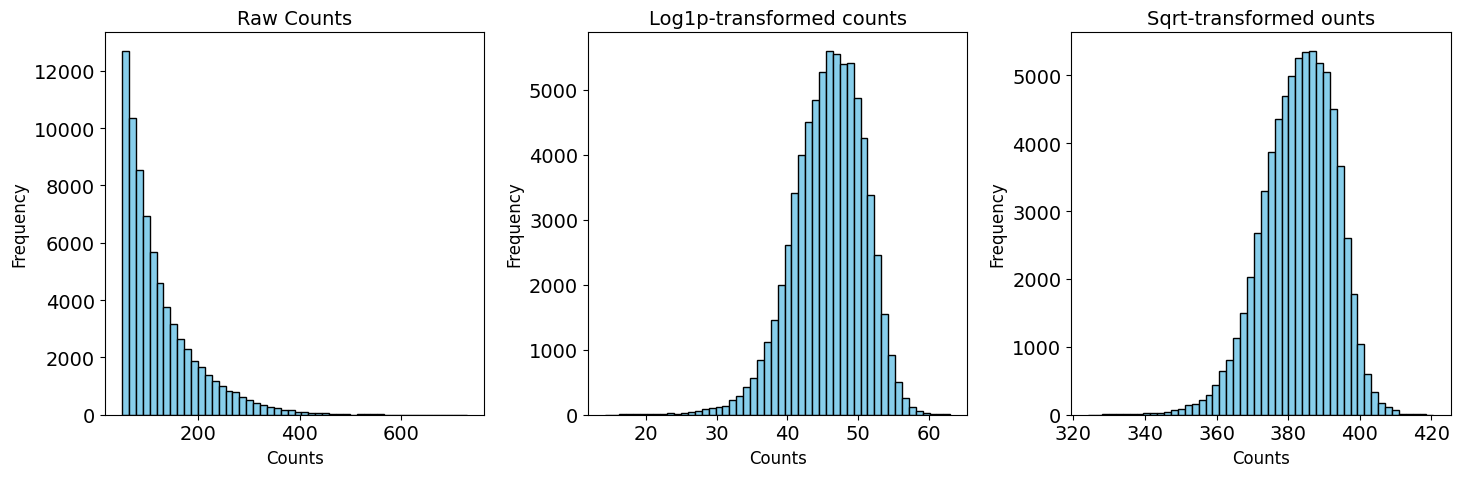

0-proseg-with scaling


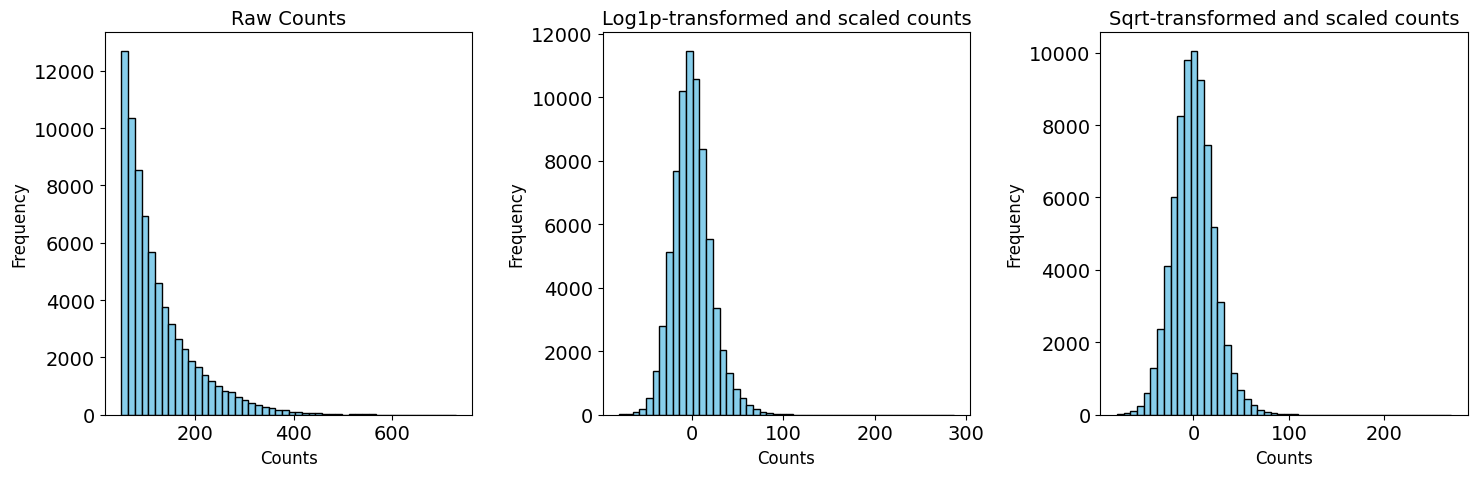

1-main-without scaling


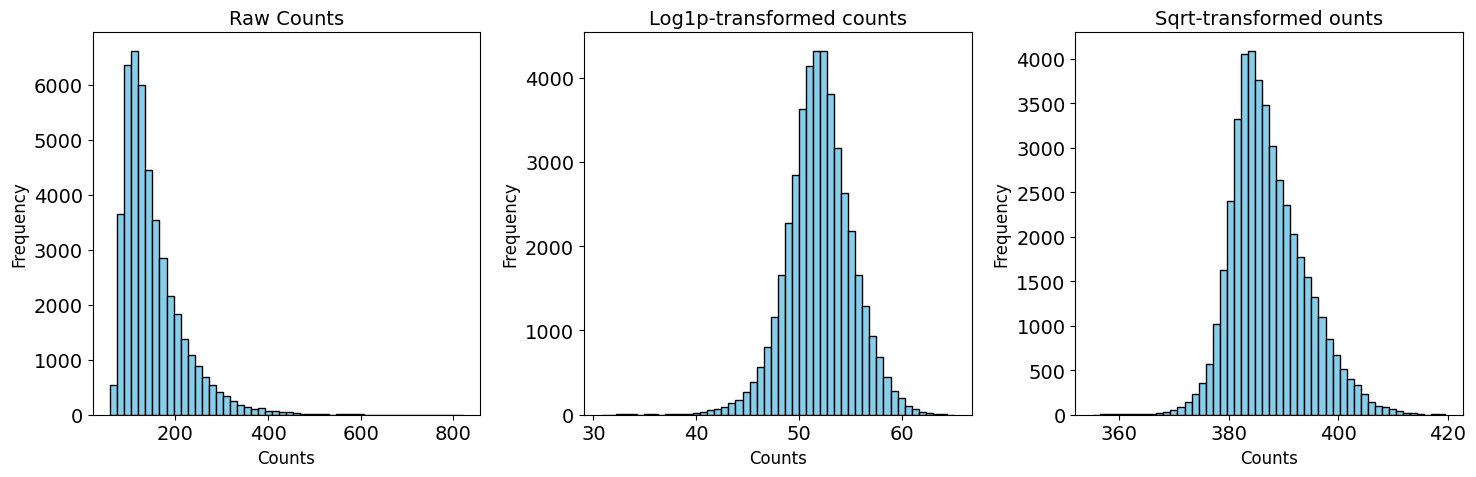

1-main-with scaling


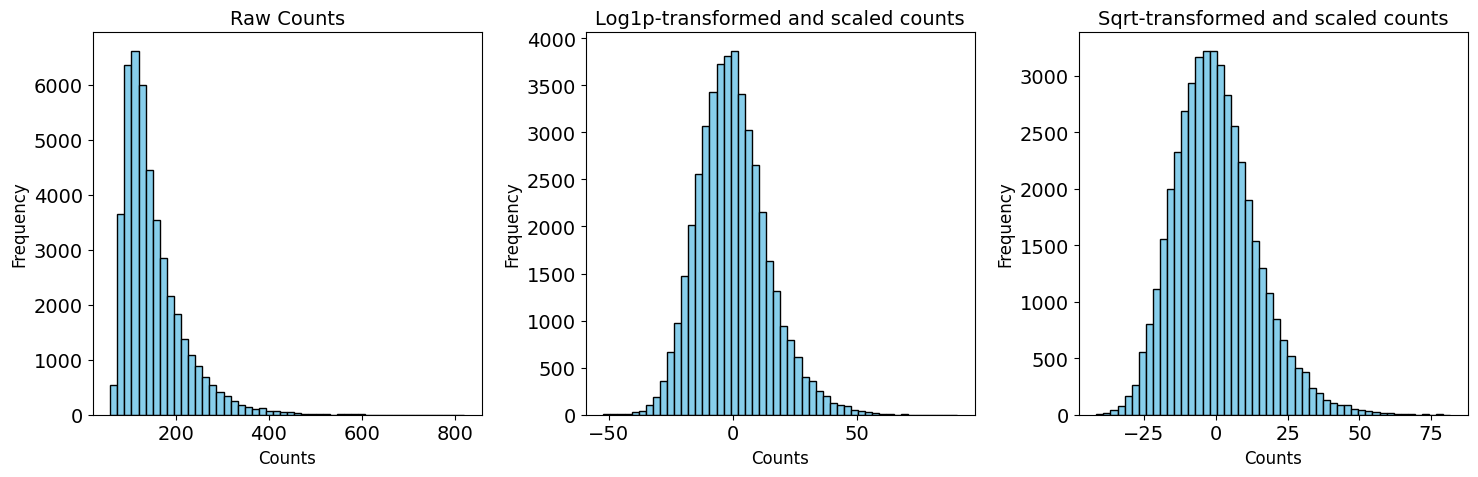

1-proseg-without scaling


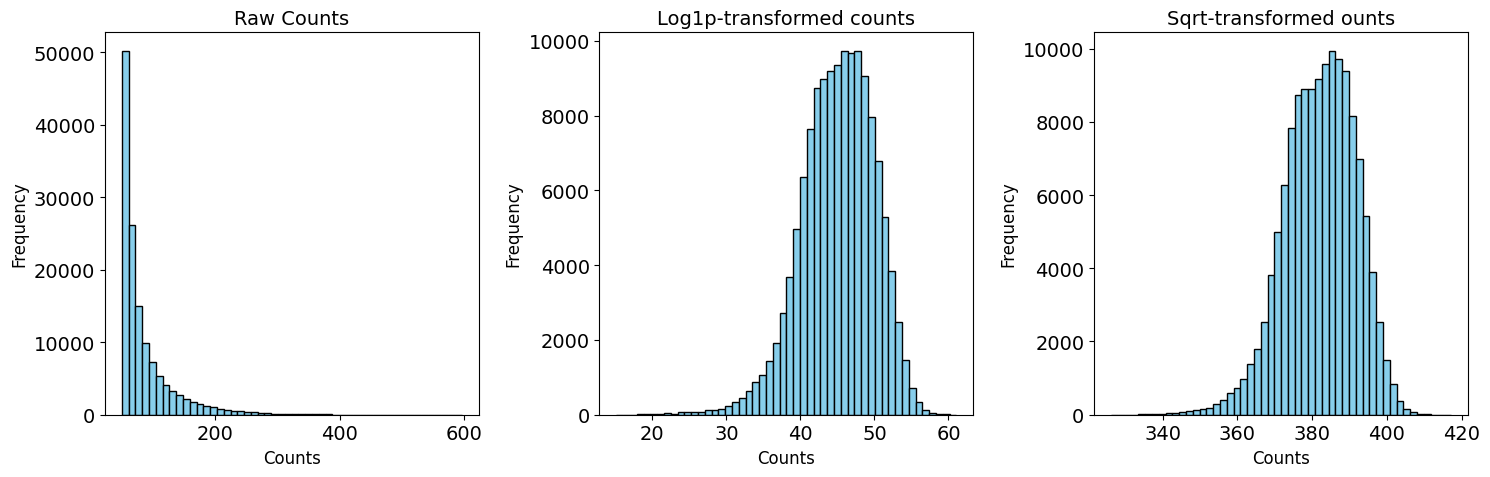

1-proseg-with scaling


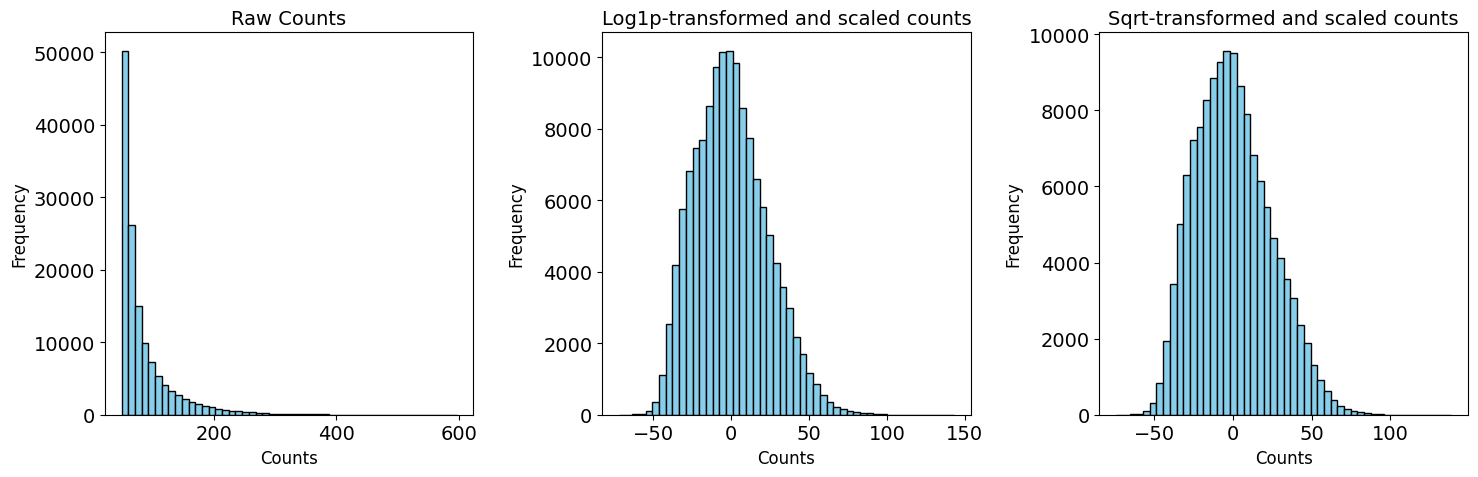

2-main-without scaling


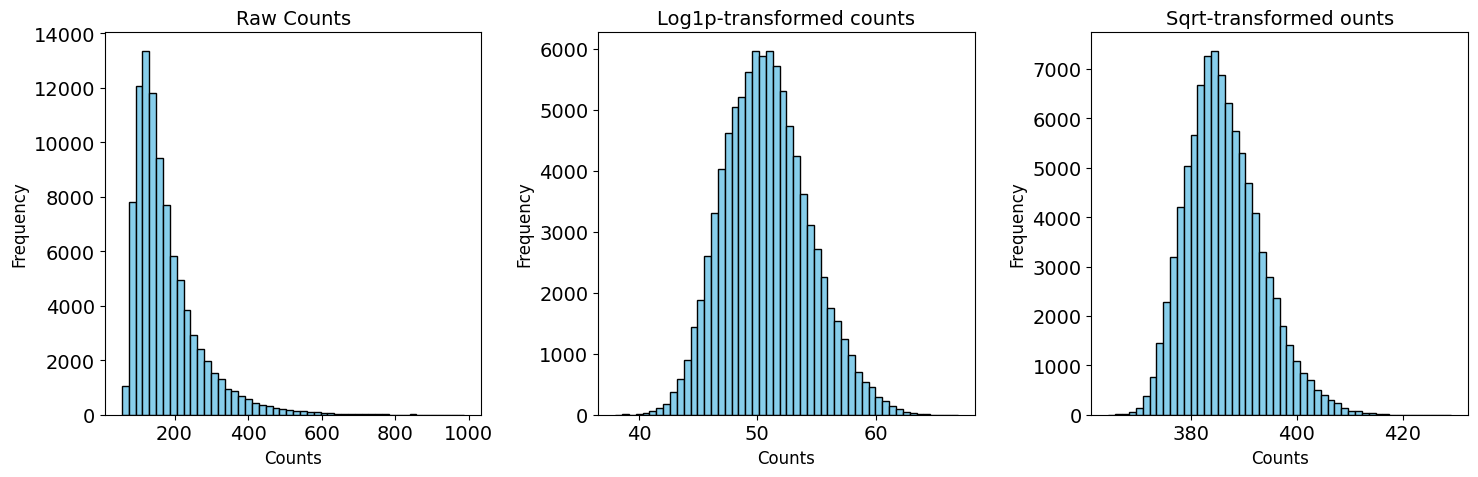

2-main-with scaling


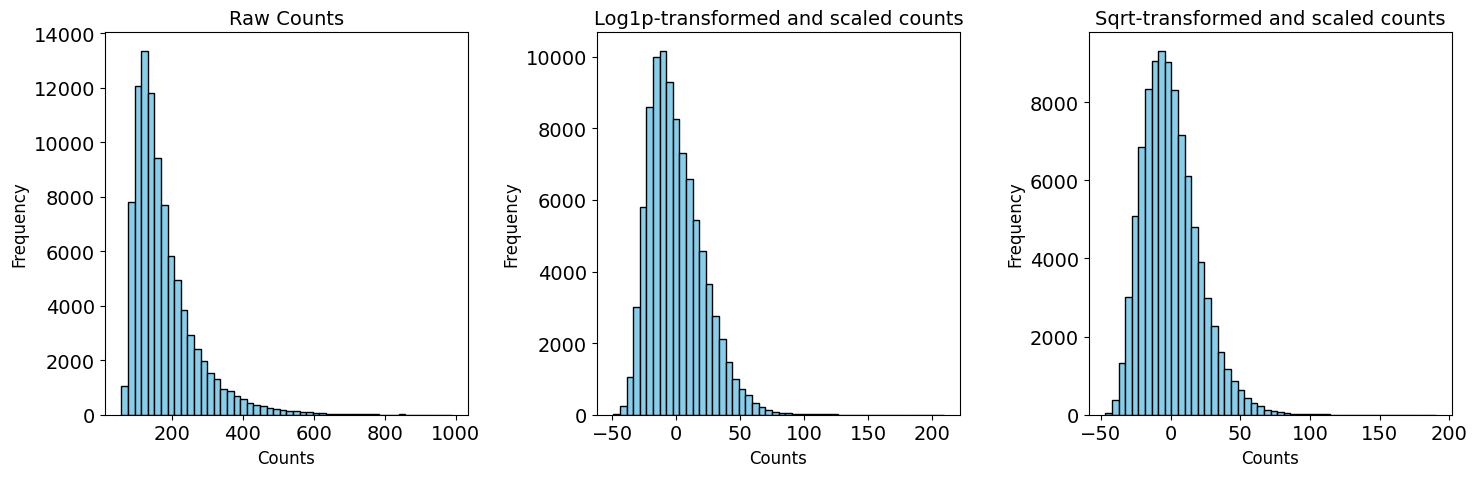

2-proseg-without scaling


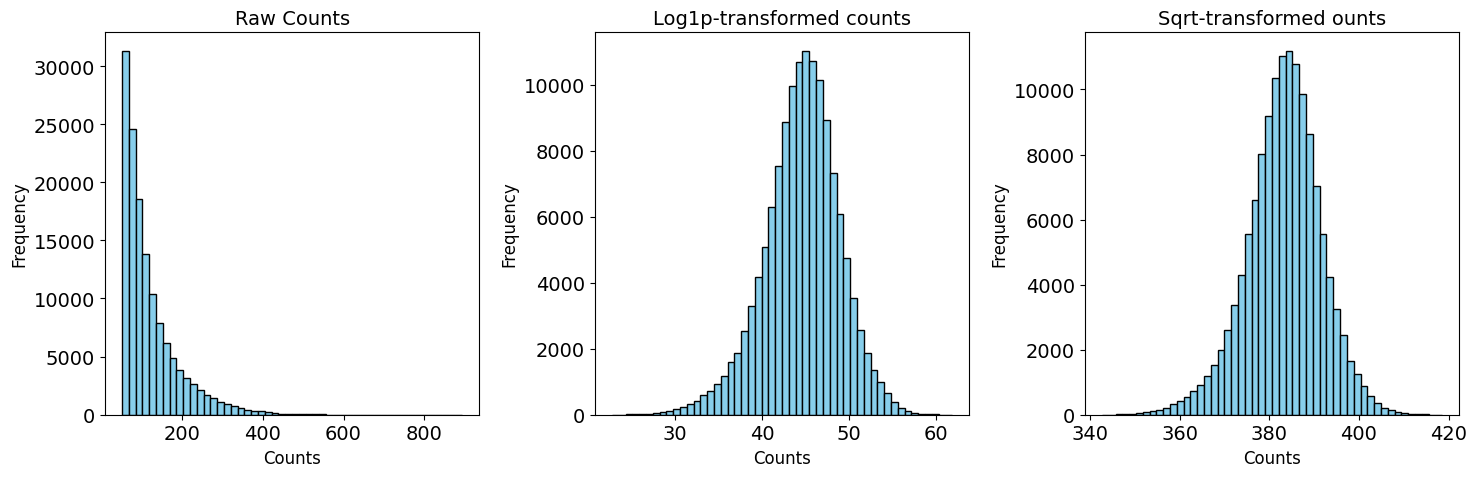

2-proseg-with scaling


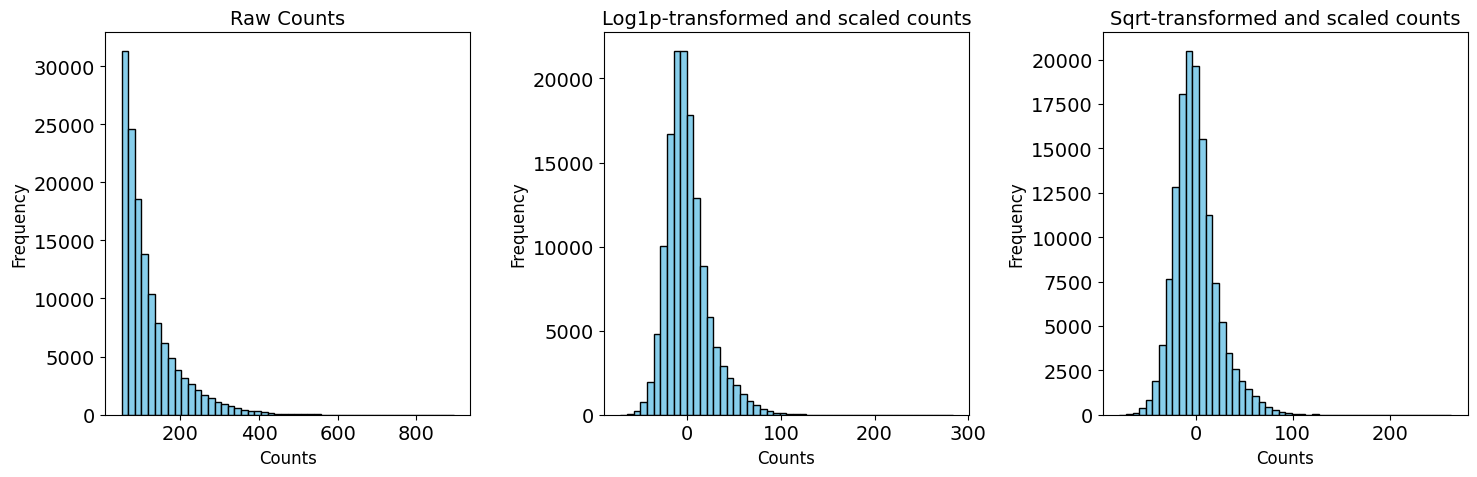

3-main-without scaling


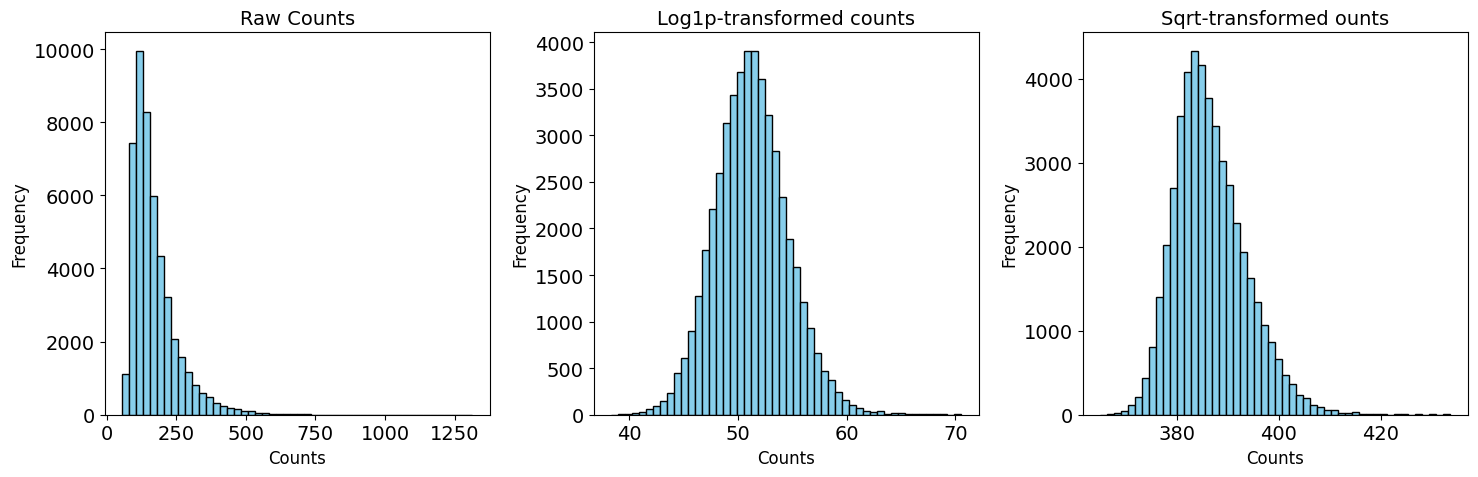

3-main-with scaling


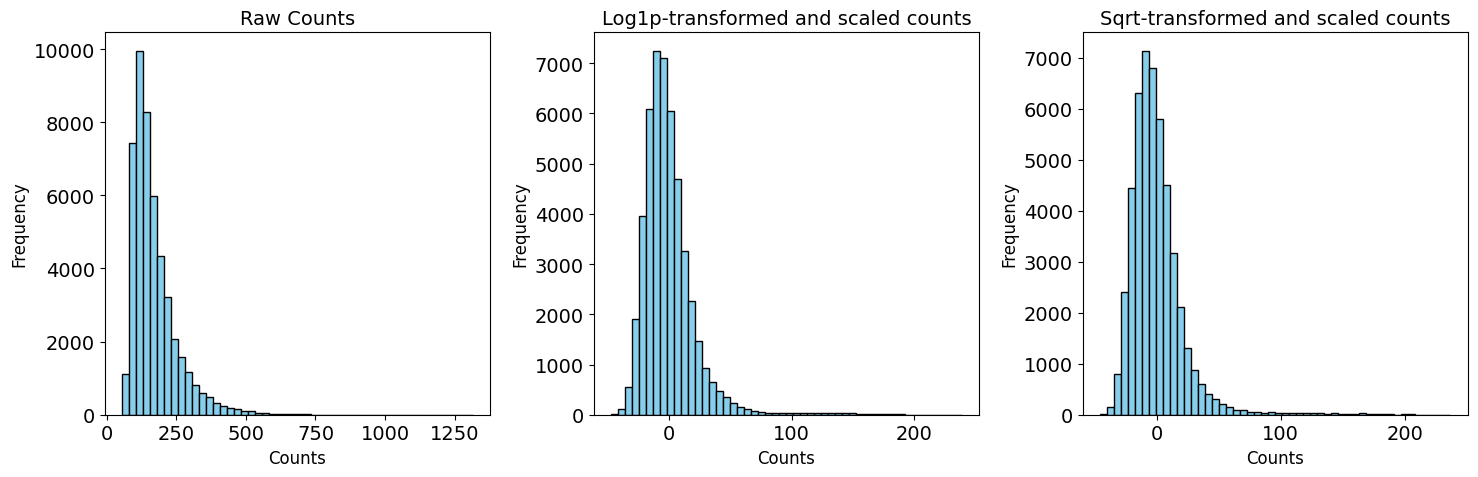

3-proseg-without scaling


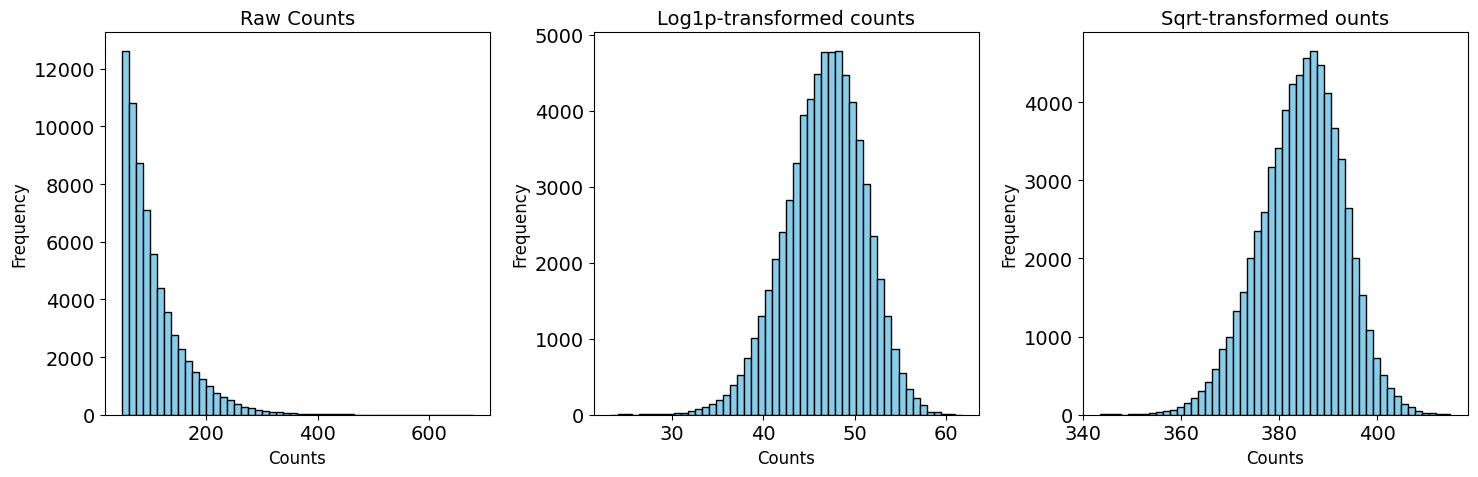

3-proseg-with scaling


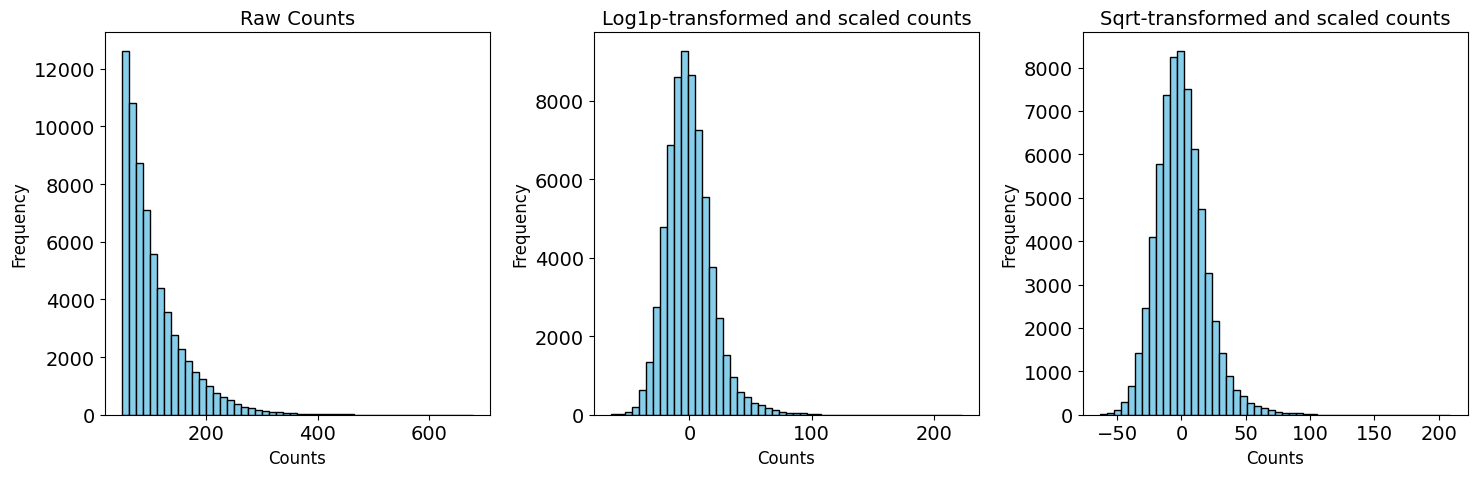

4-main-without scaling


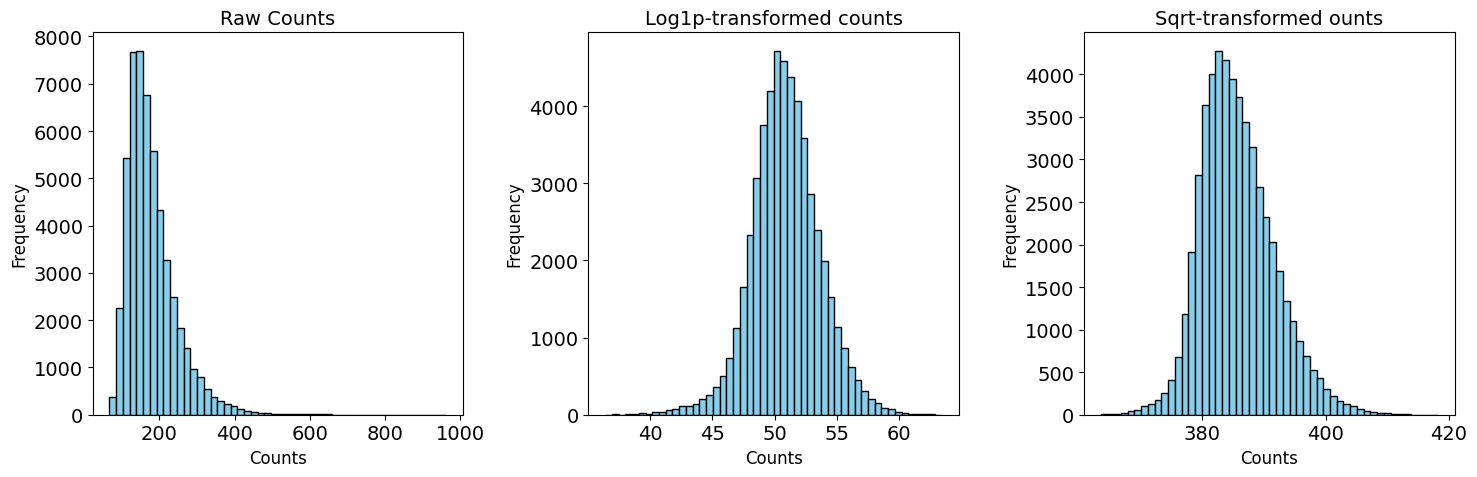

4-main-with scaling


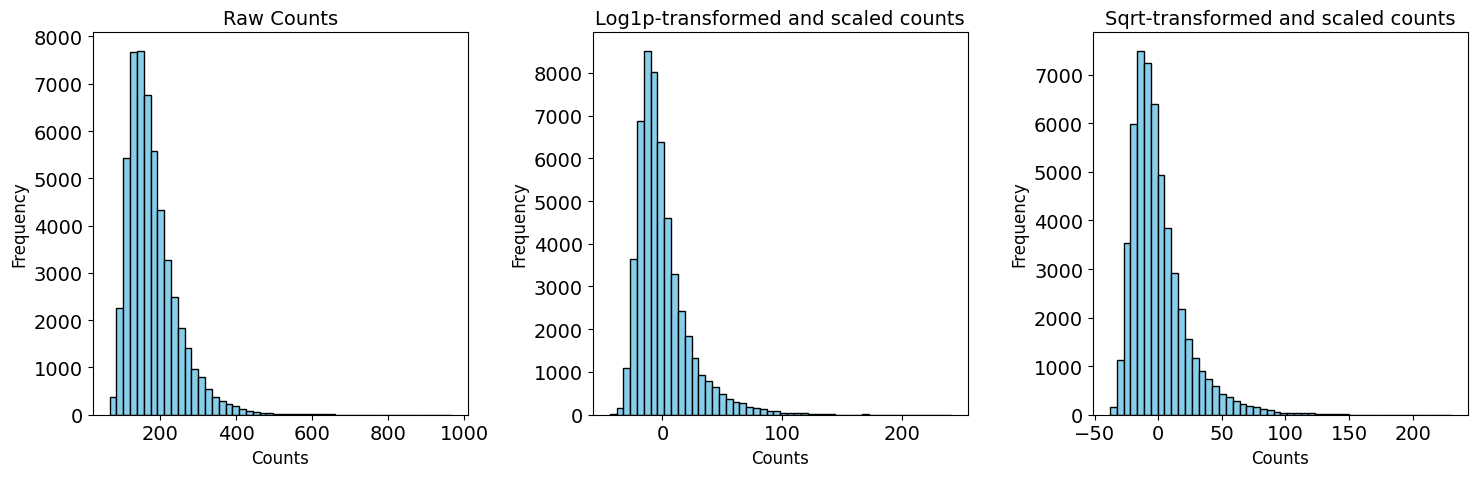

4-proseg-without scaling


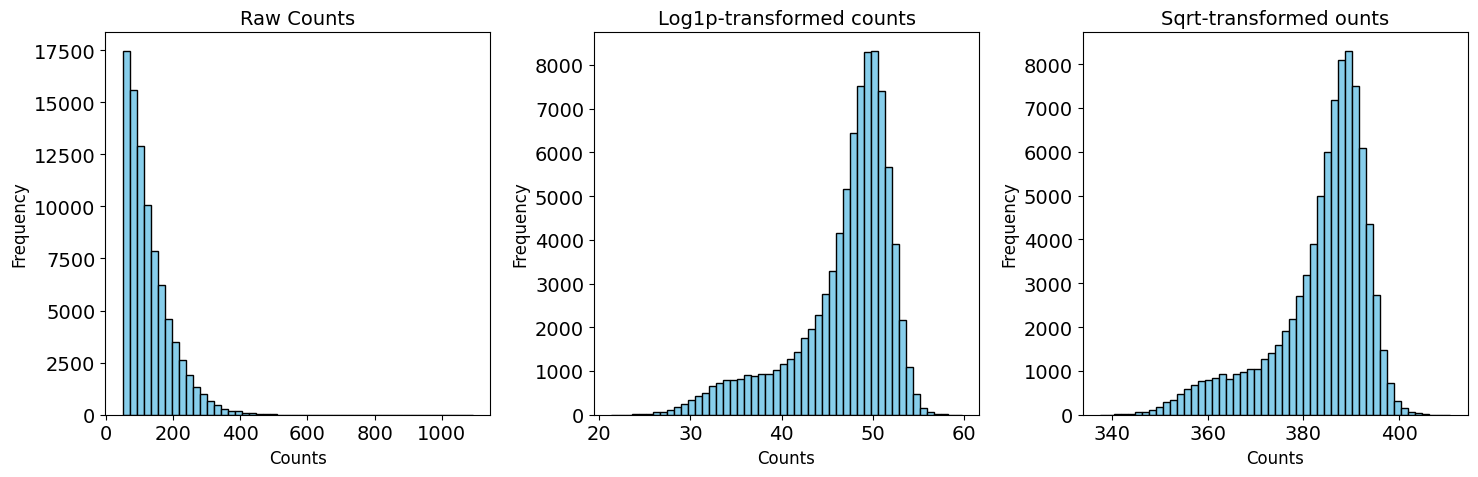

4-proseg-with scaling


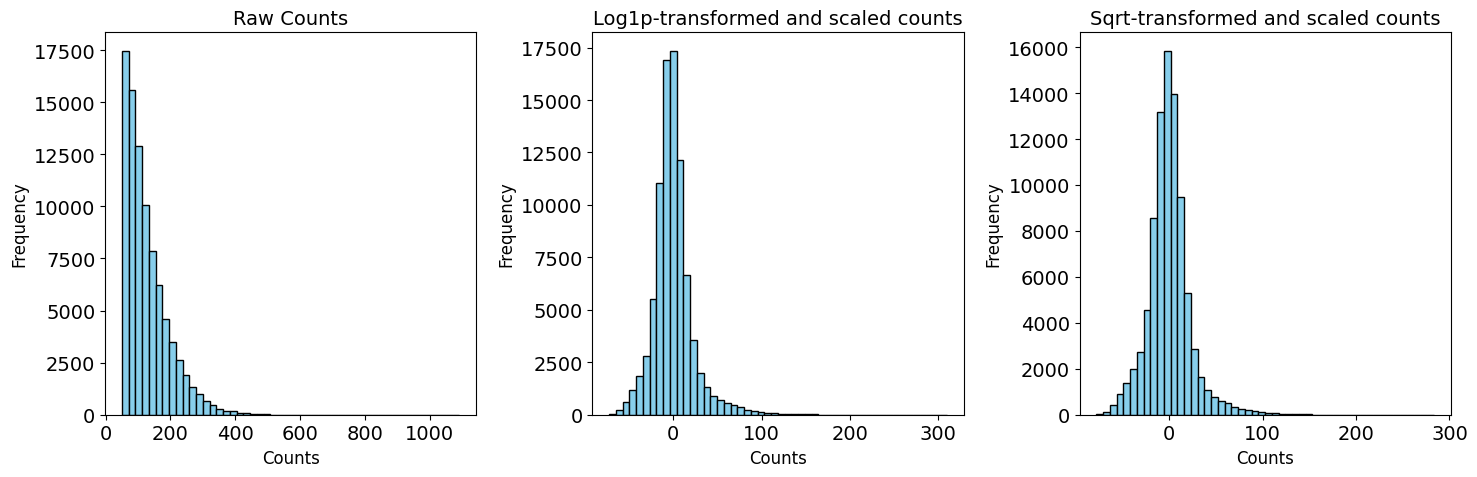

5-main-without scaling


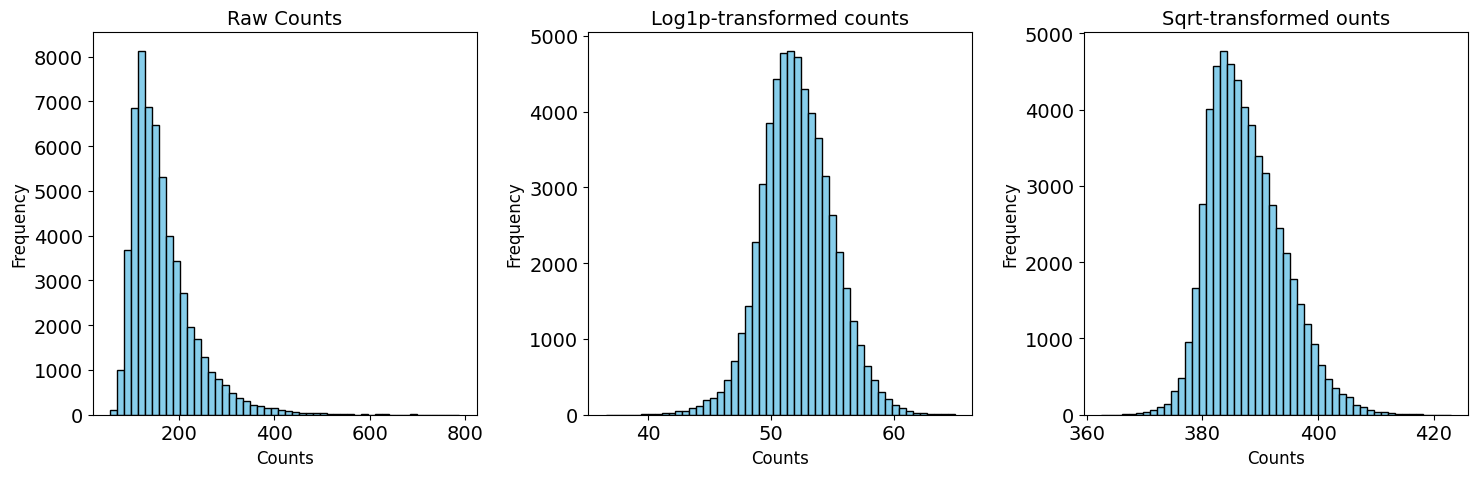

5-main-with scaling


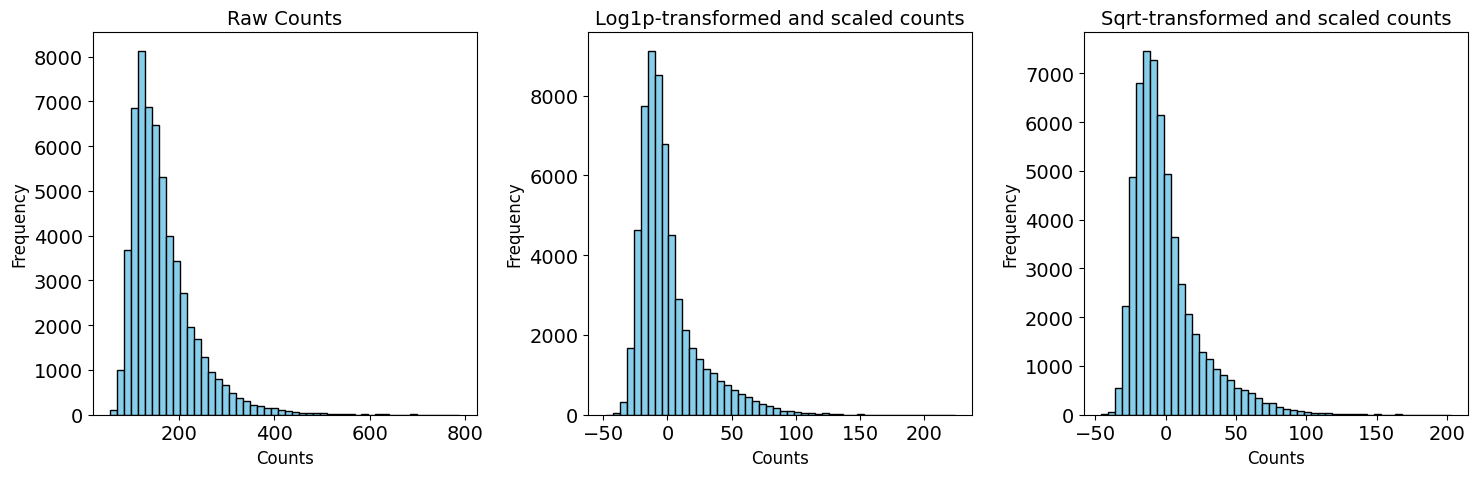

5-proseg-without scaling


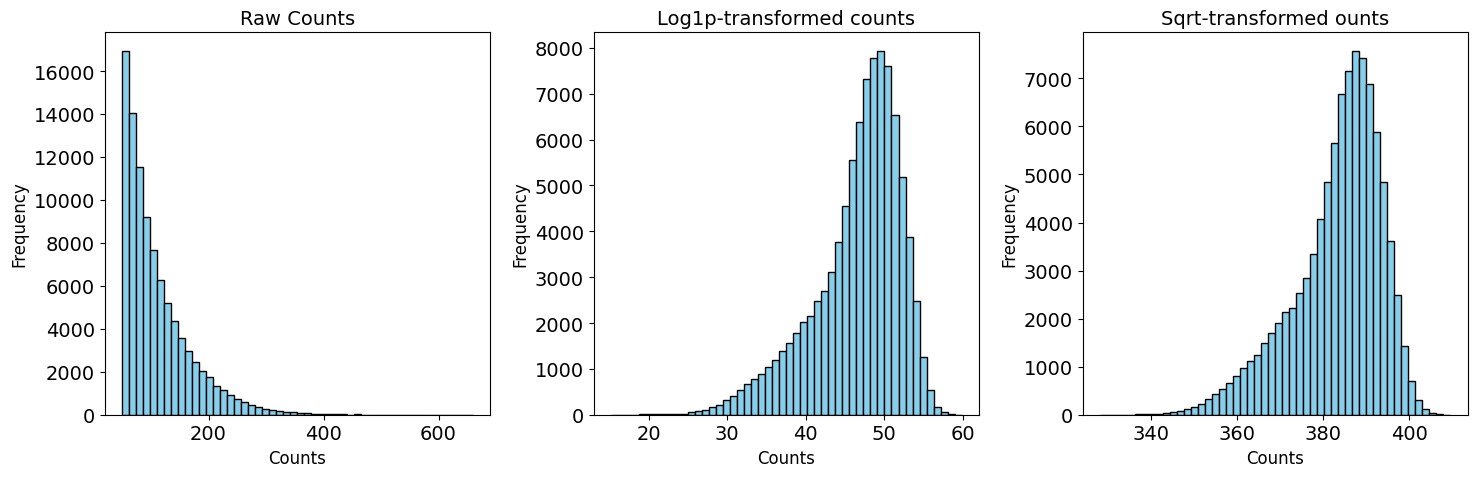

5-proseg-with scaling


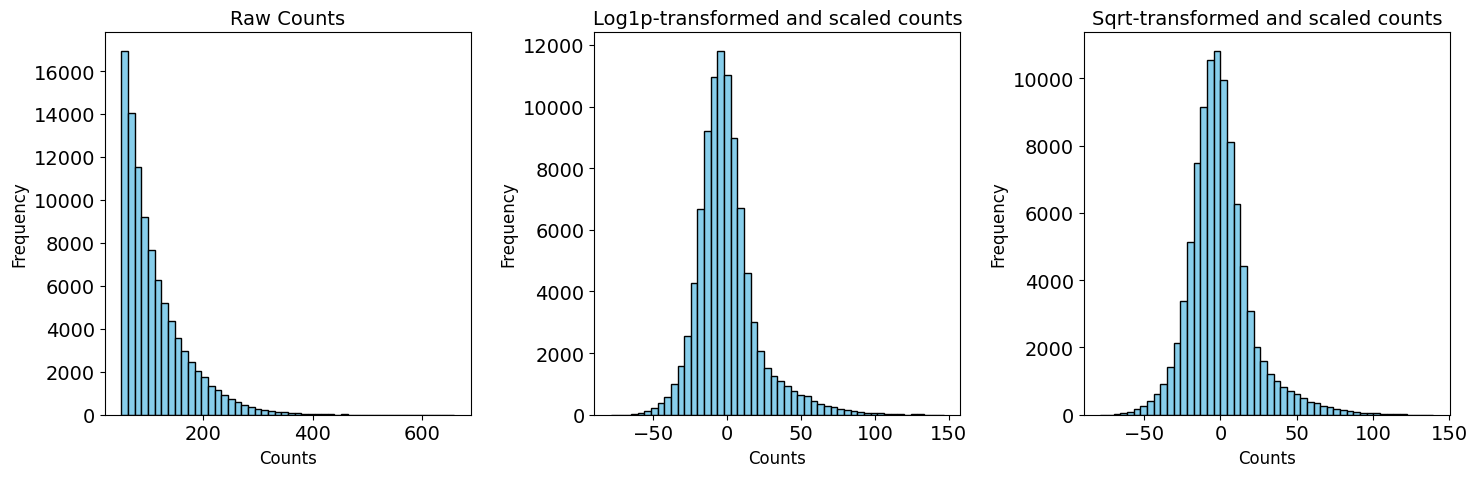

6-main-without scaling


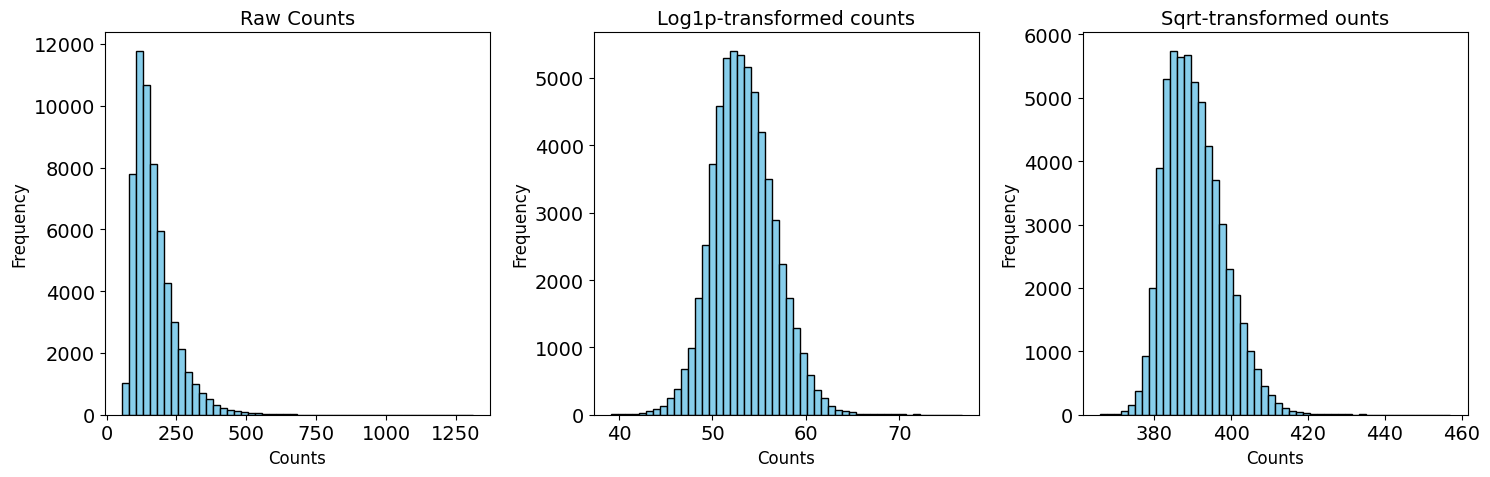

6-main-with scaling


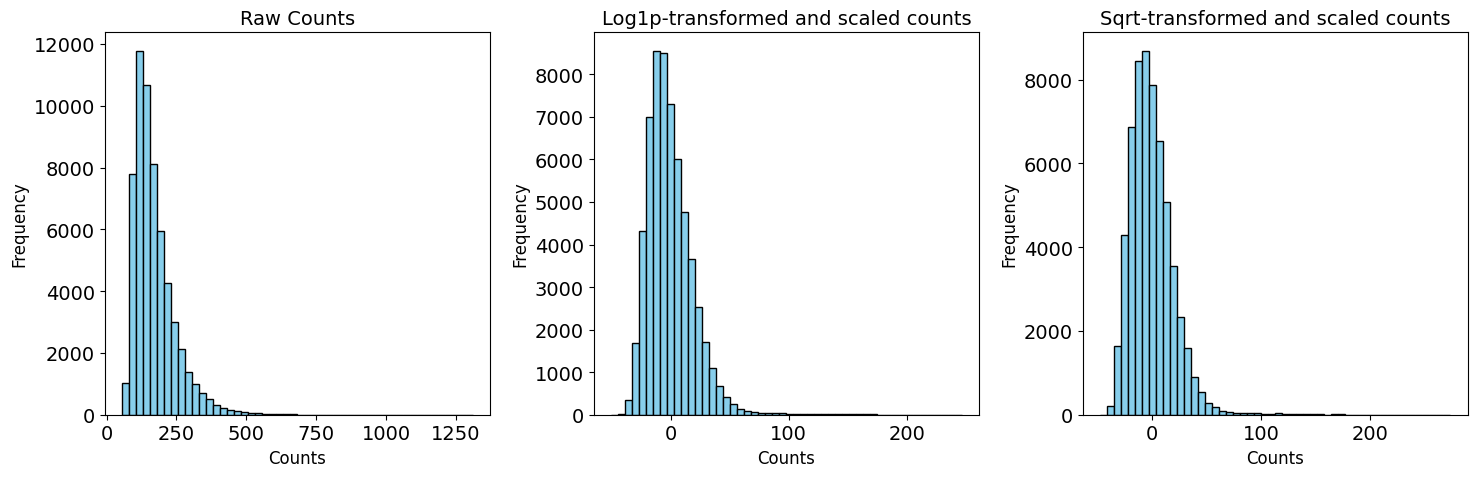

6-proseg-without scaling


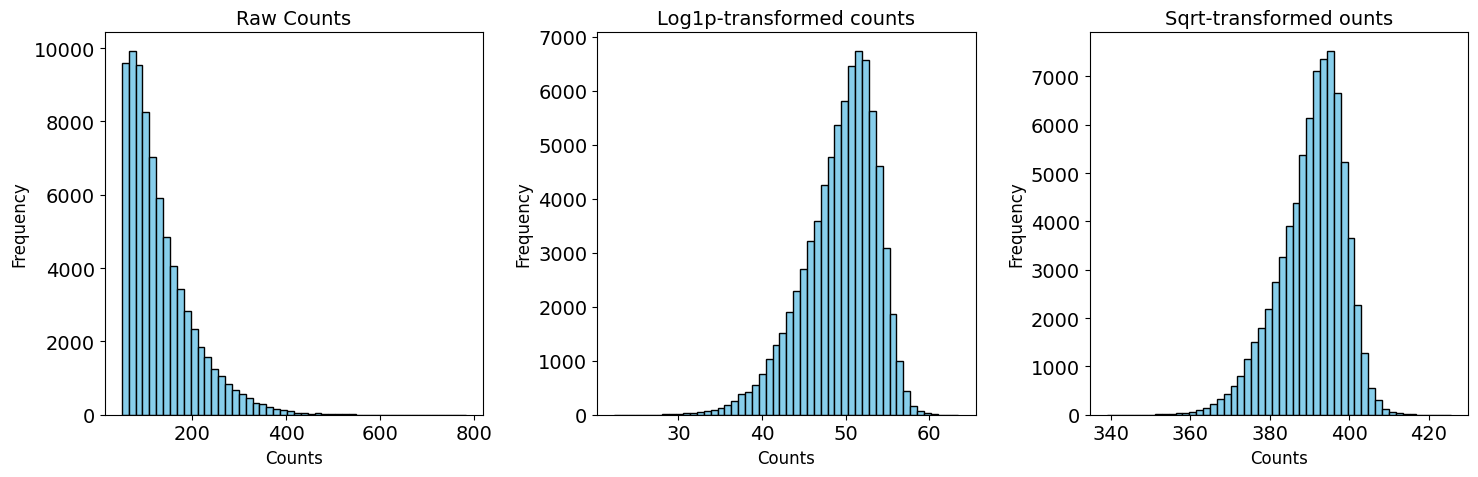

6-proseg-with scaling


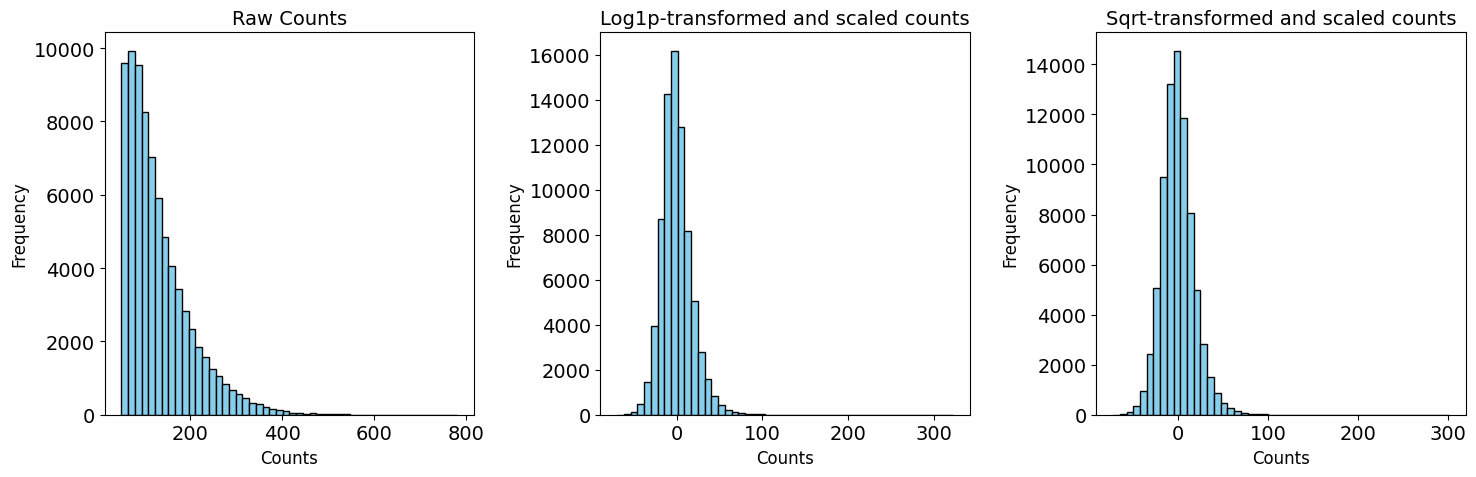

In [85]:
for meta, data in exp.iterdata():
    for k in cell_keys:
        print(f"{meta.name}-{k}-without scaling")
        test_transformations(data=data, cells_layer=k, target_sum=100, scale=False, assert_integer_counts=False)
        print(f"{meta.name}-{k}-with scaling")
        test_transformations(data=data, cells_layer=k, target_sum=100, scale=True, assert_integer_counts=False)

In [86]:
exp

InSituExperiment with 7 samples:
           uid  CITAR  slide_id       sample_id  Region  ...     Sample Name Metastasis type     H number              HE           panCK
0     3d377351  +++--      3621  Region_1-14...       1  ...  Colorectal ...             NaN  1414/18 IIA  C:\Users\ge...  C:\Users\ge...
1     039bf1f8  +++--      3621  Region_2-14...       2  ...  Lymph node ...     synchronous  1414/18 IIS  C:\Users\ge...  C:\Users\ge...
2     1c928862  +++--      3621  Region_3-33...       3  ...  Lung metast...    asynchronous  3311/18 IVA  C:\Users\ge...  C:\Users\ge...
3     18755ab6  +++--      3621  Region_4-14...       4  ...  Liver metas...     synchronous   1414/18 IC  C:\Users\ge...  C:\Users\ge...
4     3ee0776f  +++--      3991  Region_1-53...       1  ...  Colorectal ...             NaN  5316/18 IVC  C:\Users\ge...  C:\Users\ge...
5     4e08eb69  +++--      3991  Region_2-53...       2  ...  Lymph node ...     synchronous  5316/18 IVS  C:\Users\ge...  C:\Users\ge...
6

In [87]:
from insitupy.preprocessing import normalize_and_transform

In [88]:
normalize_and_transform(
    data=exp,
    cells_layer="main",
    transformation_method='log1p',
    target_sum=100,
    scale=True
)

7it [00:08,  1.21s/it]


In [89]:
normalize_and_transform(
    data=exp,
    cells_layer="proseg",
    transformation_method='log1p',
    target_sum=100,
    scale=True,
    assert_integer_counts=False # proseg counts are not integers
)

7it [00:14,  2.12s/it]


Move scaled data into layers and add the unscaled data into `adata.X`.

In [90]:
for k in cell_keys:
    print(k)
    for _, data in tqdm(exp.iterdata()):
        data.cells[k].matrix.layers[f"scaled_log1p"] = data.cells[k].matrix.X.copy()
        data.cells[k].matrix.X = data.cells[k].matrix.layers["log1p"]

main


7it [00:00, 15.23it/s]


proseg


7it [00:00,  9.46it/s]


# Save data after normalization

In [92]:
pp_path = data_path.parent / "crc_data_pp"

In [93]:
exp.saveas(pp_path)

100%|██████████| 7/7 [19:08<00:00, 164.09s/it]


In [94]:
exp = InSituExperiment.read(pp_path)
exp.load_all()

100%|██████████| 7/7 [00:28<00:00,  4.10s/it]


## Export anndatas for cell type annotation

### Check if the obs_names are unique

In [95]:
exp.make_obs_names_unique(cells_layer="main")

Make `obs_names` unique.


In [96]:
exp.make_obs_names_unique(cells_layer="proseg")

Make `obs_names` unique.


Generate a collection of the anndatas. This could be a feature in the future to lazily view the adatas together.

## Save data after making the cell names unique

In [97]:
exp.save()

100%|██████████| 7/7 [01:42<00:00, 14.63s/it]


#### Export anndatas

In [98]:
adata_export = data_path.parent / "adata_export_proseg"
adata_export.mkdir(exist_ok=True)

In [103]:
for meta, xd in exp.iterdata():
    xd.cells["proseg"].matrix.write(adata_export / f'{meta.name}-{meta["uid"]}.h5ad')

### Work with collections

In [133]:
exp.collection

AnnCollection object with n_obs × n_vars = 1453333 × 280
  constructed from 7 AnnData objects
    view of obsm: 'spatial'
    view of layers: 'counts', 'log1p', 'norm_counts', 'scaled_log1p'
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'n_genes', 'uid'

In [138]:
ad = exp.collection.to_adata()

## Dimensionality reduction and clustering

In [ ]:
data = exp.data[0].copy()

In [ ]:
data

InSituData
Method:		Xenium
Slide ID:	0003621
Sample ID:	Region_1-1414_18_IIA
Path:		None
Metadata file:	.ispy
    ➤ images
       nuclei:	(27352, 34139)
       HE:	(27352, 34139, 3)
    ➤ cells
       MultiCellData with main layer 'main'
           matrix
               AnnData object with n_obs × n_vars = 144669 × 280
               obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'n_genes'
               var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
               obsm: 'spatial'
               layers: 'counts', 'norm_counts', 'log1p', 'scaled_log1p'
           boundaries
               BoundariesData object with 2 entries:
                   cells
                   nuclei
       
       Additional layers with keys: 'proseg'
    ➤ transcripts
       DataFrame with shape Del

In [28]:
from insitupy.preprocessing import reduce_dimensions

In [ ]:
reduce_dimensions(
    data=data,
    cells_layer="main",
    method="umap"
)

Dimensionality reduction...


c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
from insitupy.preprocessing import clustering

In [ ]:
clustering(
    data=data,
    cells_layer="main",
    method="leiden"
)

C:\Users\ge37voy\Github\InSituPy\insitupy\preprocessing\anndata.py:121: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


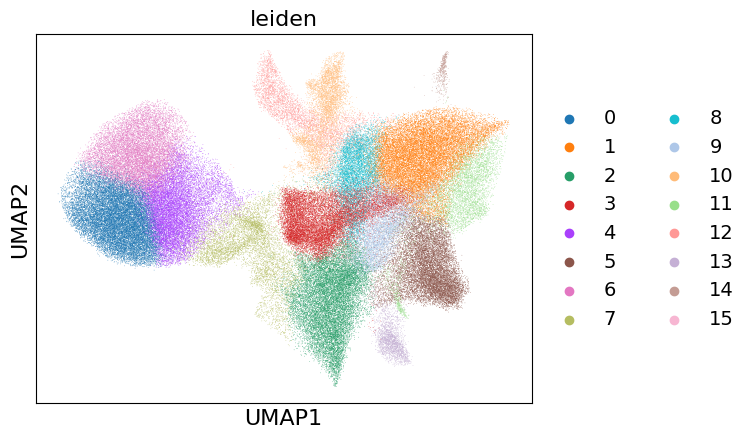

In [ ]:
sc.pl.umap(data.cells.matrix, color="leiden")

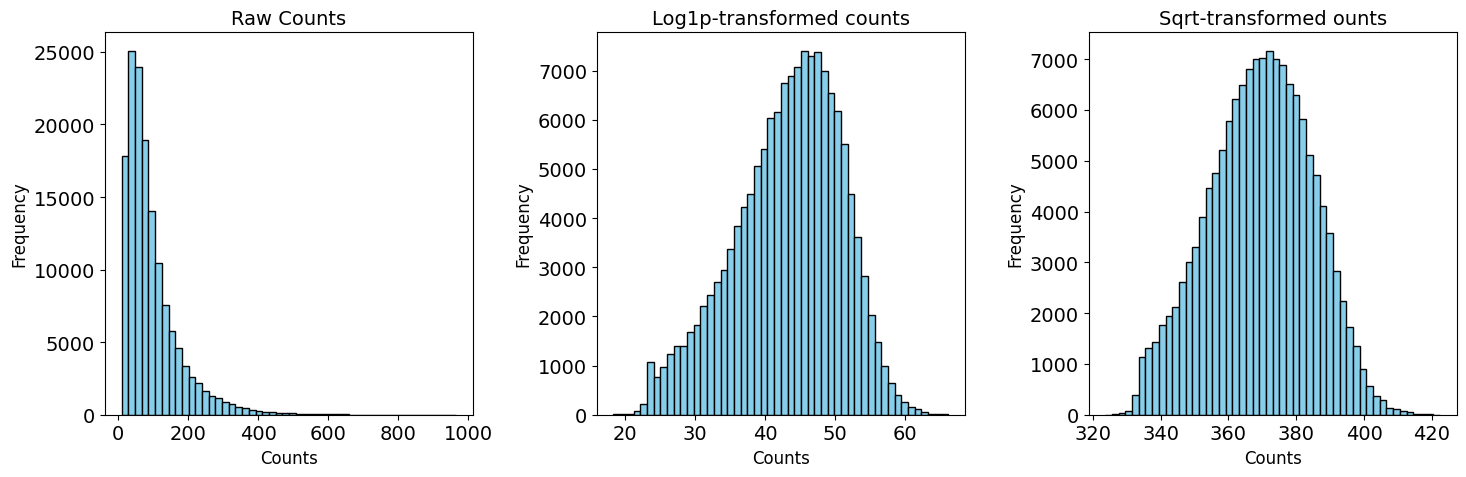

In [ ]:
test_transformations(
    data.cells.matrix, target_sum=100, scale=False
    )

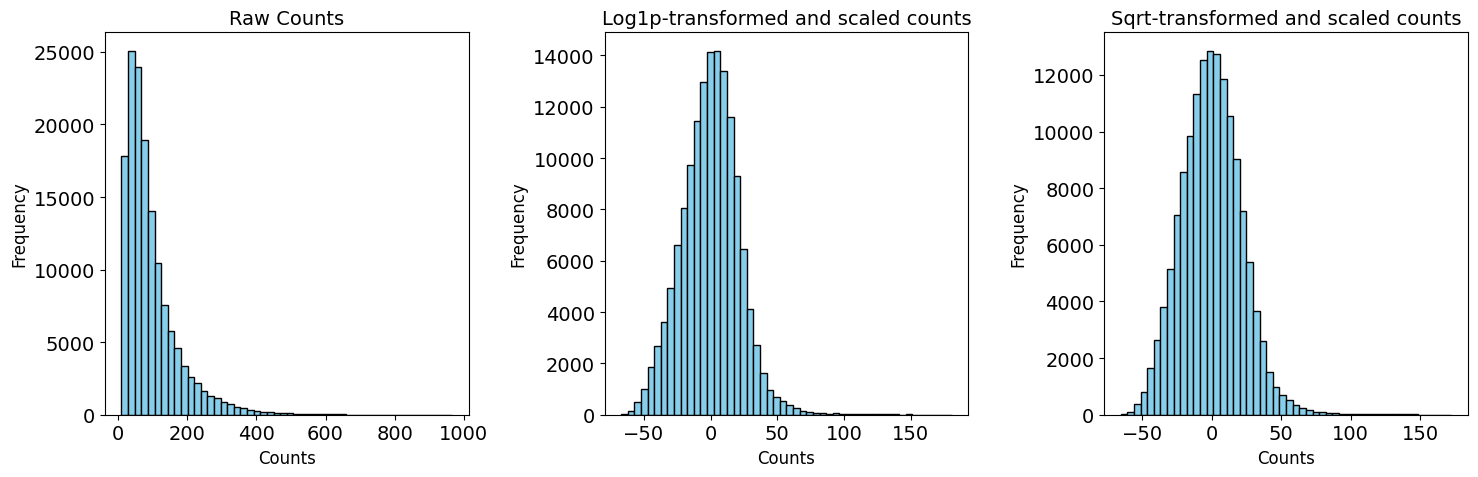

In [ ]:
test_transformations(
    data.cells.matrix, target_sum=100, scale=True
    )

In [7]:
exp

InSituExperiment with 7 samples:
           uid  CITAR  slide_id       sample_id  Region  ...     Sample Name Metastasis type     H number              HE           panCK
0     13613e64  +++--      3621  Region_1-14...       1  ...  Colorectal ...             NaN  1414/18 IIA  C:\Users\ge...  C:\Users\ge...
1     e3641b3b  +++--      3621  Region_2-14...       2  ...  Lymph node ...     synchronous  1414/18 IIS  C:\Users\ge...  C:\Users\ge...
2     99afae32  +++--      3621  Region_3-33...       3  ...  Lung metast...    asynchronous  3311/18 IVA  C:\Users\ge...  C:\Users\ge...
3     4080a94e  +++--      3621  Region_4-14...       4  ...  Liver metas...    asynchronous   1414/18 IC  C:\Users\ge...  C:\Users\ge...
4     b372990c  +++--      3991  Region_1-53...       1  ...  Colorectal ...             NaN  5316/18 IVC  C:\Users\ge...  C:\Users\ge...
5     c0177a85  +++--      3991  Region_2-53...       2  ...  Lymph node ...     synchronous  5316/18 IVS  C:\Users\ge...  C:\Users\ge...
6

In [11]:
exp.data[0].cells['main']

matrix
    AnnData object with n_obs × n_vars = 151305 × 280
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
boundaries
    BoundariesData object with 2 entries:
        cells
        nuclei

In [14]:
exp.data[0].cells['proseg']

matrix
    AnnData object with n_obs × n_vars = 151507 × 280
    obs: 'centroid_x', 'centroid_y', 'centroid_z', 'fov', 'cluster', 'volume', 'population'
    obsm: 'spatial'
boundaries
    BoundariesData object with 2 entries:
        cells

In [ ]:

insitupy.pp.calculate_qc_metrics()

AttributeError: module 'insitupy.preprocessing' has no attribute 'calculate_qc_metrics'